# <center> APS1017 Demand Forecasting Project </center>
##<center>Group 3</center>


---
## <center>Table of Content</center>
   1. Summary
   2. Explanation and visualization of the data
    -  Data cleaning
    -  Graphs over time for each client
    -  Graphs over time for each material
    -  Graphs over time for each pair of client and material
   3. Forecasting Methods
    - Moving Average (MA)
    - Autoregressive Integrated Moving Average (ARIMA)
   4. Explanation of Major Functions
    - Data cleaning
    - Data preparation according to the user input
    - Data interpolation
    - Forecasting with MA
    - Forecasting with ARIMA
   5. How to use

---

##1. Summary

Demand forecasting is the process of making estimates of customer demand based on historical sales data.  It is a powerful tool commonly adopted by businesses as it provides a prediction on the goods and services that customers will likely purchase in the foreseeable future.  The obtained information can be critical for many business processes, such as inventory management, risk assessment, capacity planning, etc. Our project aims to develop a useful demand forecasting tool that can perform three major steps: 1).accept user’s specifications on the client, the material, and the target forecast date; 2). Implement two forecasting methods; 3).provide accurate predictions on future demand in response to the input client and material at the specified time. This report consists of four major sections. Section 2 will explore the input data through visualization and understanding of its fields. Section 3  introduces the two chosen forecasting methods, which are the Moving Average (MA) and Autoregressive Integrated Moving Average (ARIMA). The third section explains the major functions that serve the purpose of making accurate predictions, and the last section outlines the procedures on how to use the forecasting tool from a user’s perspective.  


#####*Before proceeding to the next section, execute the following code block to set up the python libraries and load data file*

In [ ]:
#import libraries
!pip install pmdarima
import pandas as pd
import numpy as np
import pmdarima as pm
import warnings
import io
import matplotlib.pyplot as plt
from numpy import log
from itertools import compress
from google.colab import files
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import pacf
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.StringIO(uploaded['APS1017 Order data for Project.csv'].decode('utf-8')))

Saving APS1017 Order data for Project.csv to APS1017 Order data for Project.csv


##2. Explanation and visualization of the data

The original dataset is a collection of the historical sales data with four fields.  It records the detail of transactions ranging from December 5th, 2019 to February 24th, 2020. Besides the date of purchase, each tuple/transaction also records information on the client, purchased material, and the sale quantity.  The clients are annotated by String “c1” to “c10” whereas a 7-digit code uniquely identifies each material. During this 3-month period, there are 118 pairs of client and material as each client ordered only some of the materials. Before the exploratory data analysis, data-cleaning is performed with detailed steps explained in the later section. 
 
 


#####*Data Cleaning*

In [ ]:
def clean_data():
  ## Remove exact duplicates
  df.drop_duplicates(keep=False, inplace=True)

  ## Aggregate orders with the same date, client and material but different quantities
  df_grouped = df.groupby(['Date', 'Client', 'Material']).agg({'Order Quantity': ['sum']})
  df_grouped.columns = ['Order Sum']
  df_grouped = df_grouped.reset_index()

  ## Sort the data by date
  df_grouped['Date']=pd.to_datetime(df_grouped['Date'])
  df_grouped = df_grouped.sort_values(by='Date')
  data_grouped = df_grouped.sort_values(by='Date')
  data_grouped.set_index('Date', inplace=True)
  data_grouped.index

  ## Notes: data_grouped is used for visualization and df_grouped is used for forecasting
  df_grouped = df_grouped.reset_index()
  df_grouped.drop('index',inplace=True,axis=1)

  return data_grouped, df_grouped

In [ ]:
data_grouped, df_grouped = clean_data()

##<center> </center>
To obtain an overview of the dataset and identify any existing trends, we plotted the graphs over time for each client, each material, and each pair of client and material. The graphs for each client above show that client c1, c2, c3, c6, c7 have ordered the most types of materials during the 3-month period, which is 15, while client c9 only ordered two types of the materials. Since the transaction data only spread over three months, it is difficult to observe any seasonality. However, some peak demands of different materials coincide with the same client. Using client c1 as an example, the highest order quantity of material 11001186, 12042081, and 11000851 all happened around the last week of January 2020. Nevertheless, since the specific information about the clients and materials remains unknown, we could only conclude that order quantities are affected by the businesses or the clients and are unlikely to be affected by external factors such as seasons or time of the year.  Hence, we assume that there is no apparent common trend exists in the order quantity of the materials. 



#####*Graph over time for each client*

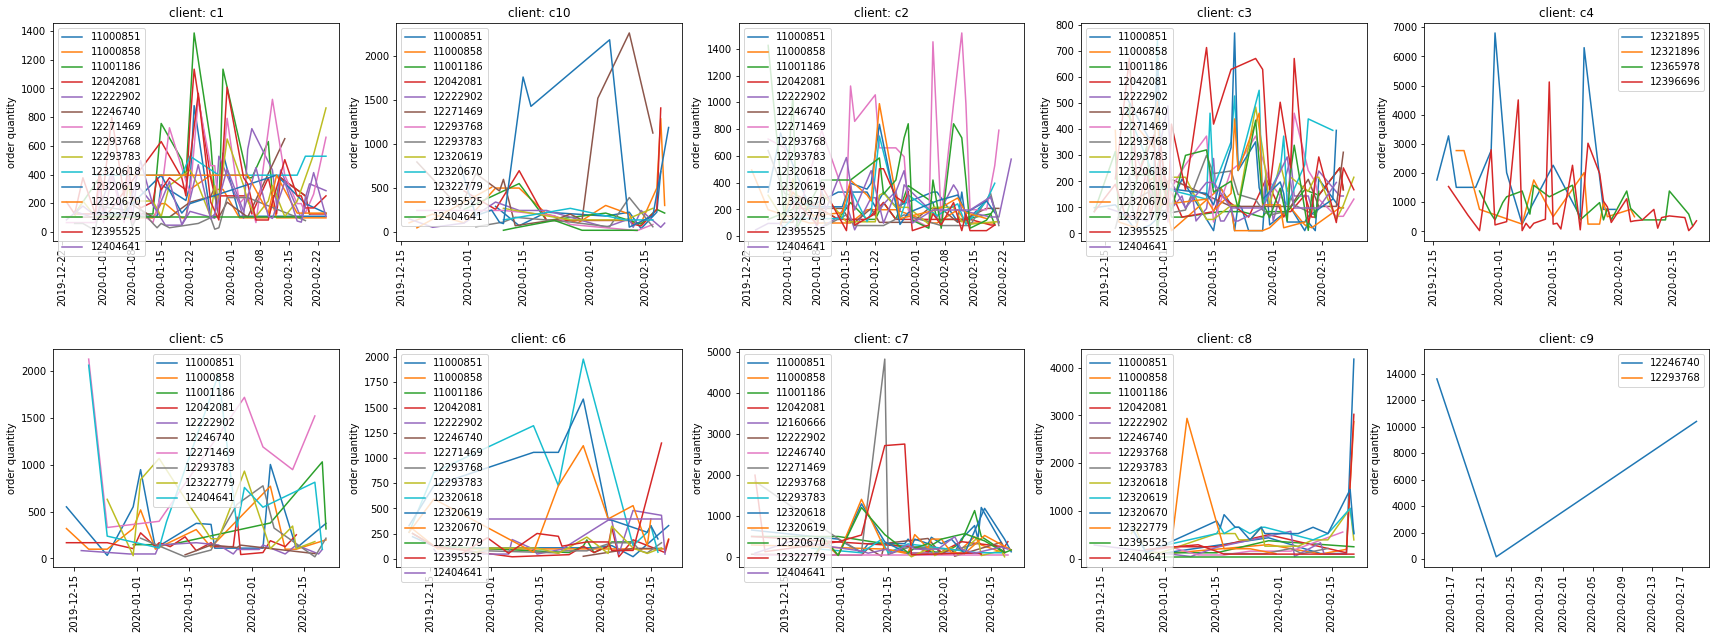

In [ ]:
## graph over time for each client
fig, axs = plt.subplots(2,5, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(left=1, right=3.3,hspace=0.5)
axs = axs.ravel()
clients = data_grouped.groupby('Client')
for i,client in zip(range(0,10),clients.groups.keys()):
  df1 = clients.get_group(client).groupby('Material')
  for mat in df1.groups.keys():
  
    axs[i].plot(df1.get_group(mat)['Order Sum'],label = str(mat))
    axs[i].tick_params(axis='x',labelrotation=90)
    axs[i].title.set_text('client: '+client)
    axs[i].set_ylabel('order quantity')
    axs[i].legend()

#####*Graph over time for each material*

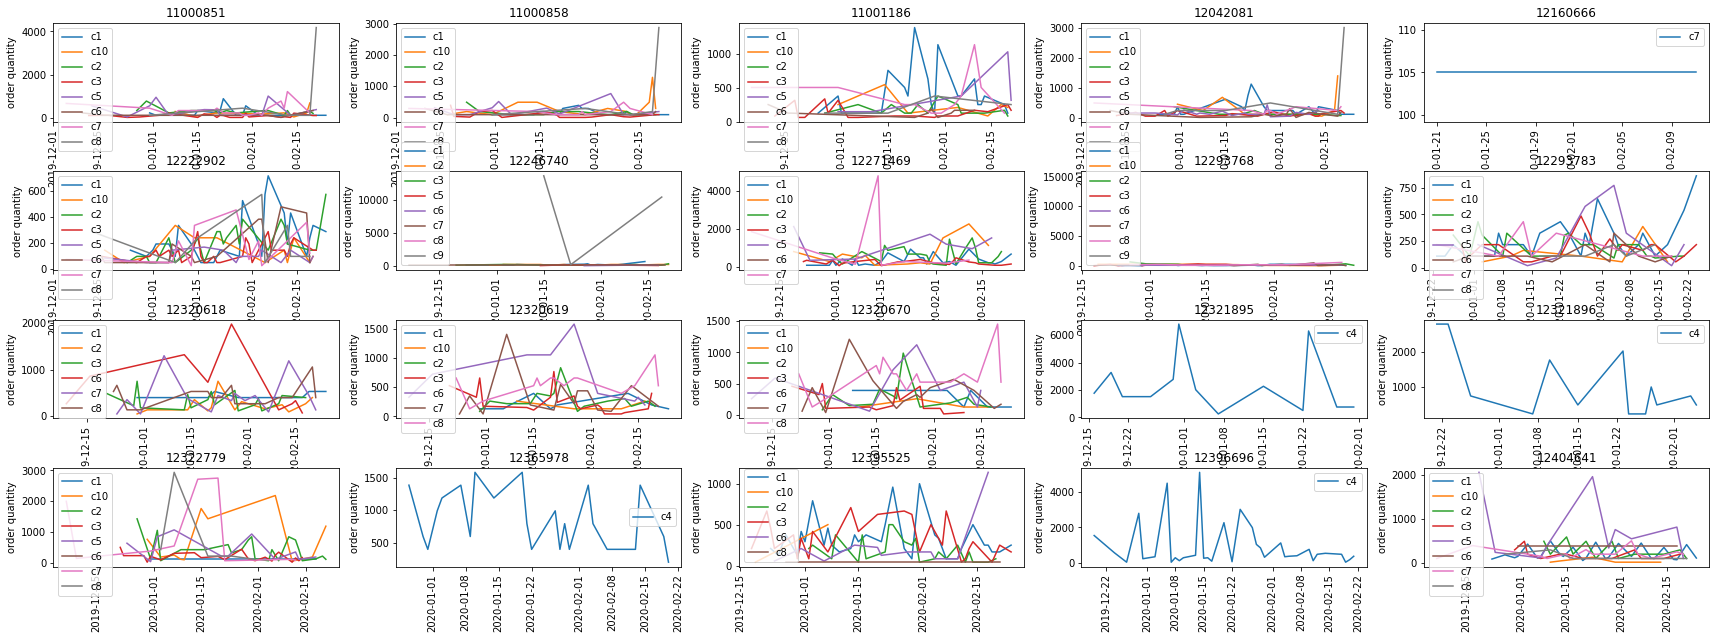

In [ ]:
## graph over time for each material
fig, axs = plt.subplots(4,5, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(left=1, right=3.3,hspace=0.5)
axs = axs.ravel()
materials = data_grouped.groupby('Material')
for i,material in zip(range(0,20),materials.groups.keys()):
  df1 = materials.get_group(material).groupby('Client')
  for mat in df1.groups.keys():
  
    axs[i].plot(df1.get_group(mat)['Order Sum'],label = str(mat))
    axs[i].tick_params(axis='x',labelrotation=90)
    axs[i].title.set_text(material)
    axs[i].set_ylabel('order quantity')
    axs[i].legend()

##<center> </center>
Different shapes can be found in the graphs for each pair of client and material due to inconsistent order frequency. Some of the graphs illustrate constant order quantity over the three months, such as client c7 - material 12160666, and some showed a monotonic increasing trend, such as client c10 - material 12395525. Most of the graphs follow a periodic pattern but with irregular fluctuations. Besides, as some of the data subsets only have very few data points with a non-continues time interval, seasonality and trends can hardly be observed, and data pre-processing is conducted for later stages. 

#####*Graph over time for each pair of client and material*

In [ ]:
def pair_plot(client_name):
  
  """
  client_name = c1,c2,c3...(str)
  """

  clients = data_grouped.groupby('Client')
  mat = clients.get_group(client_name).groupby('Material')
  fig, axs = plt.subplots(len(mat.groups)//3+1,3,figsize=(30, 30))
  fig.subplots_adjust(left=0.5, right=1.3,hspace=0.5)
  fig.suptitle('For client: '+ client_name, fontsize=80)
  axs = axs.ravel()
  for i,materials in zip(range(len(mat.groups.keys())),mat.groups.keys()):
    axs[i].plot(mat.get_group(materials)['Order Sum'],label=str(materials))
    axs[i].title.set_text('material: '+str(materials))
    axs[i].tick_params(axis='x',labelrotation=90)
    axs[i].set_ylabel('order quantity')
    axs[i].legend()
  plt.show()

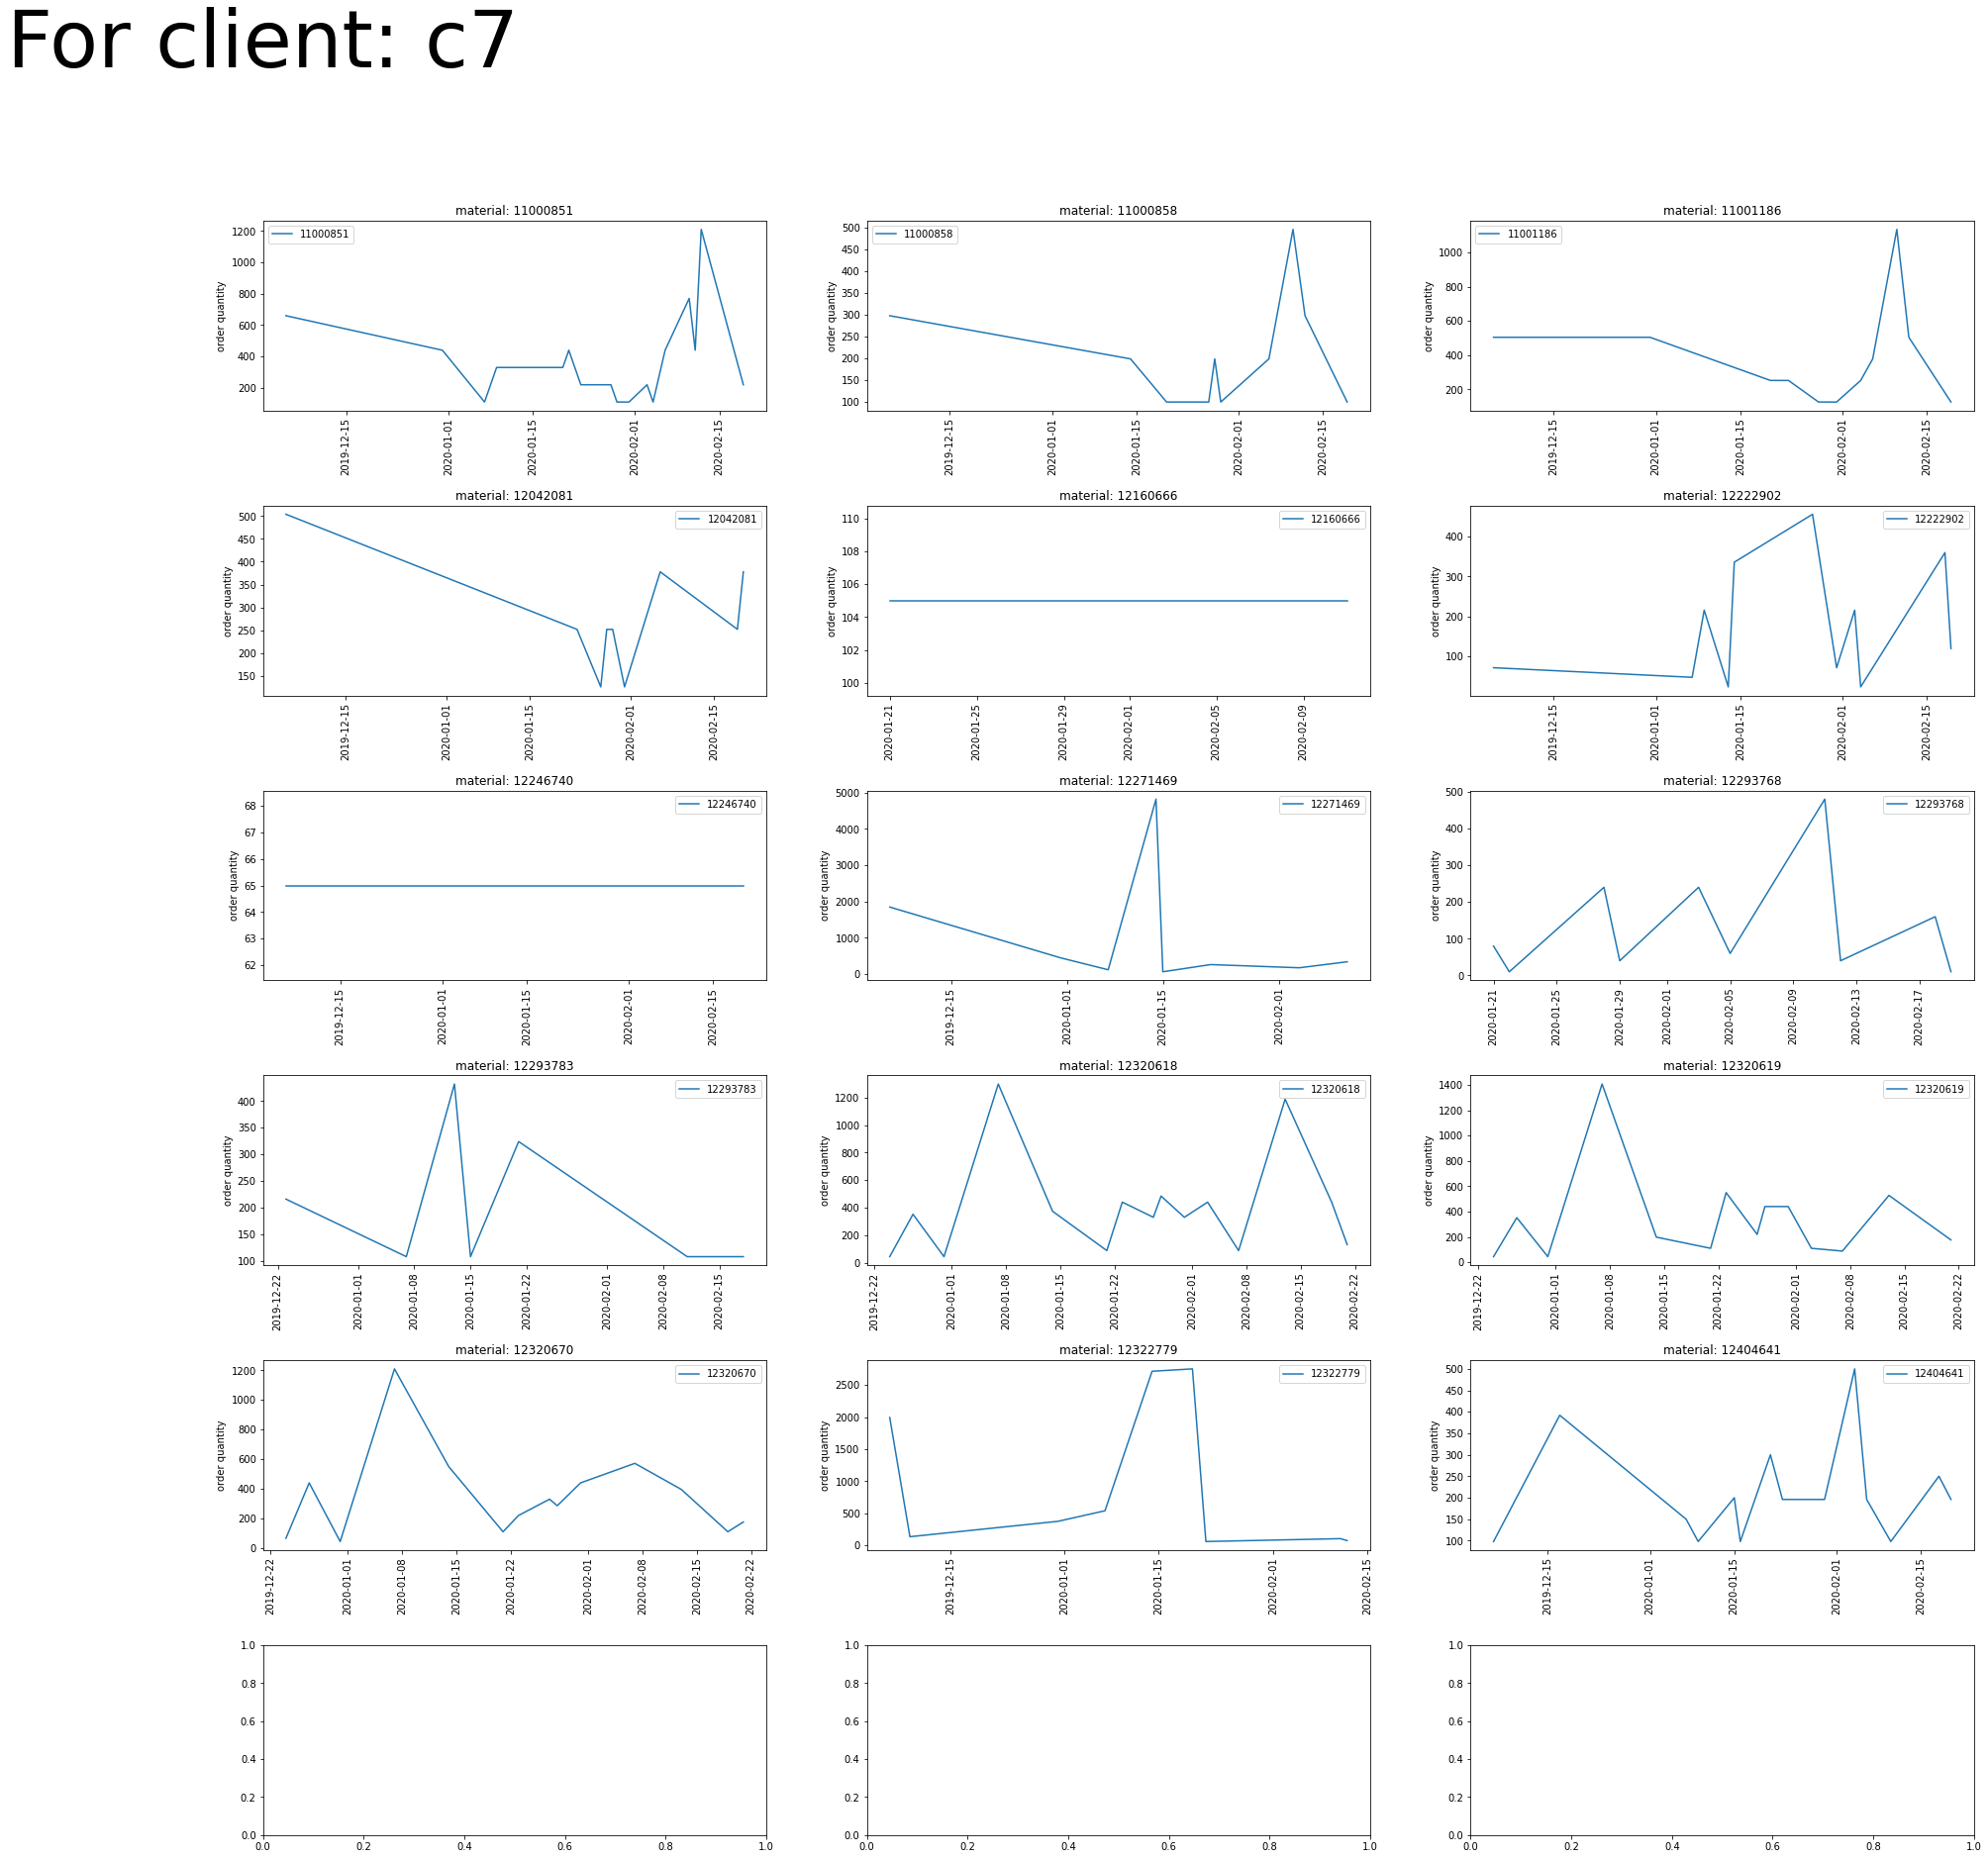

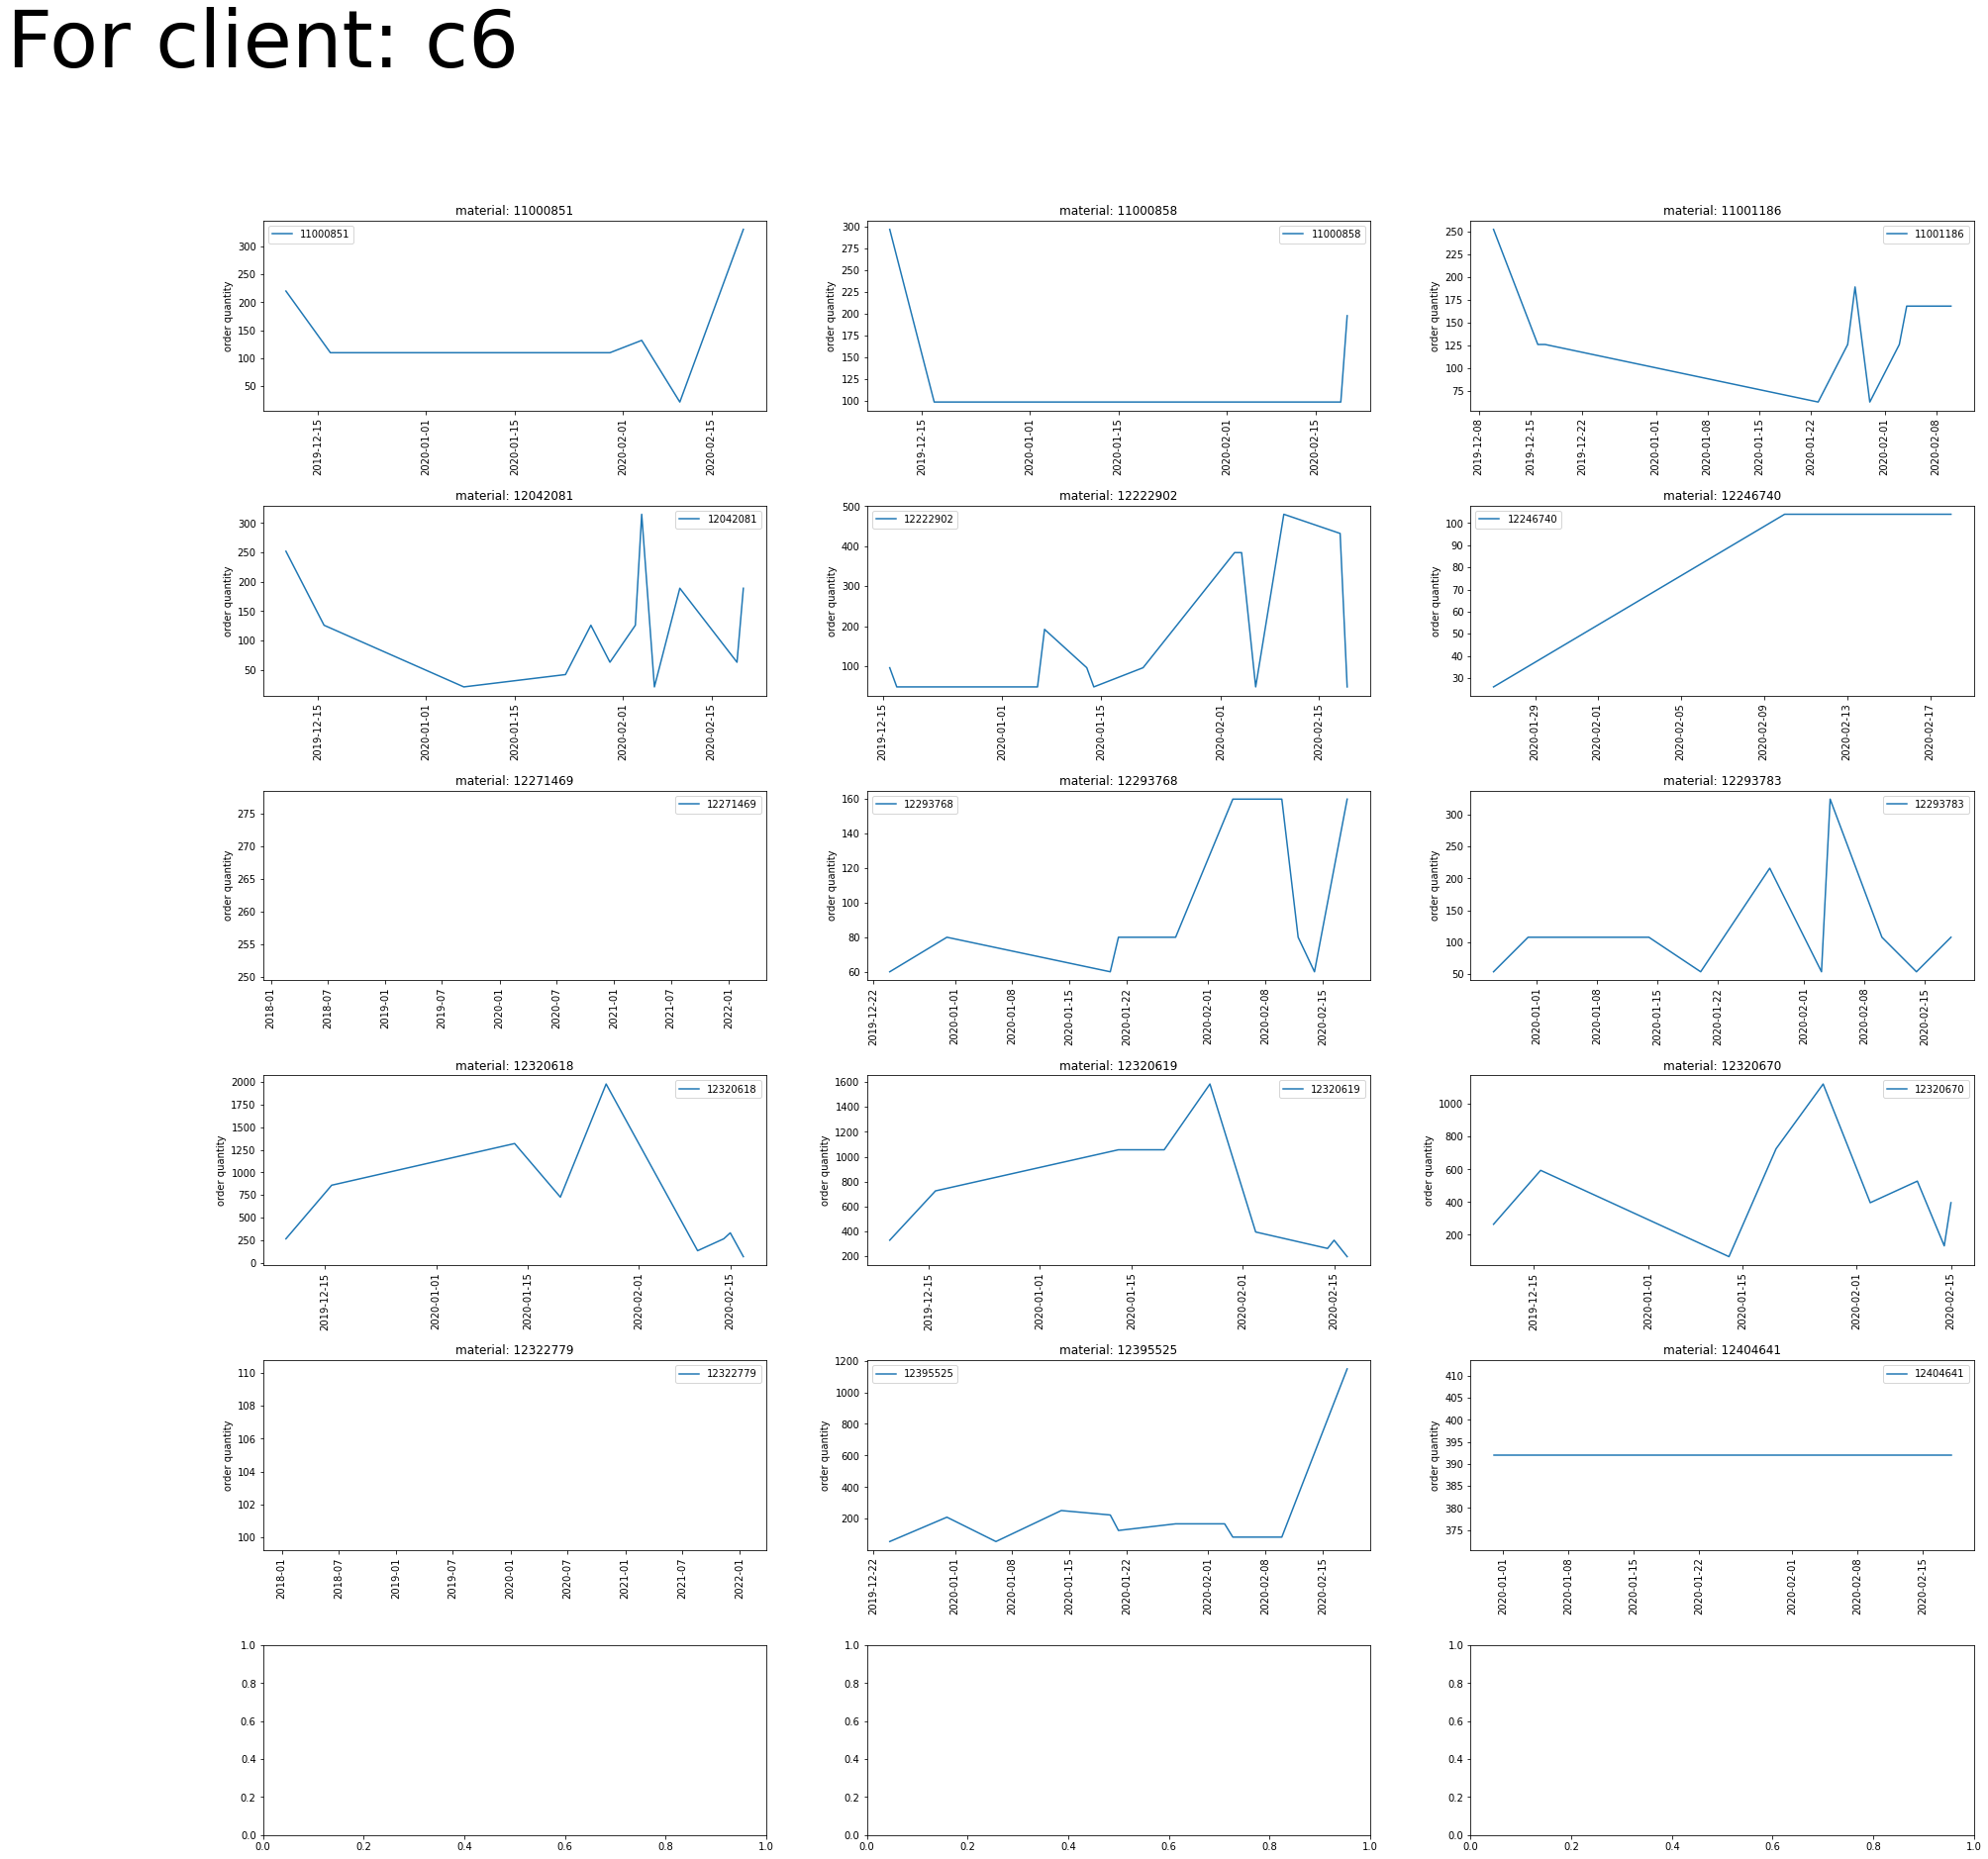

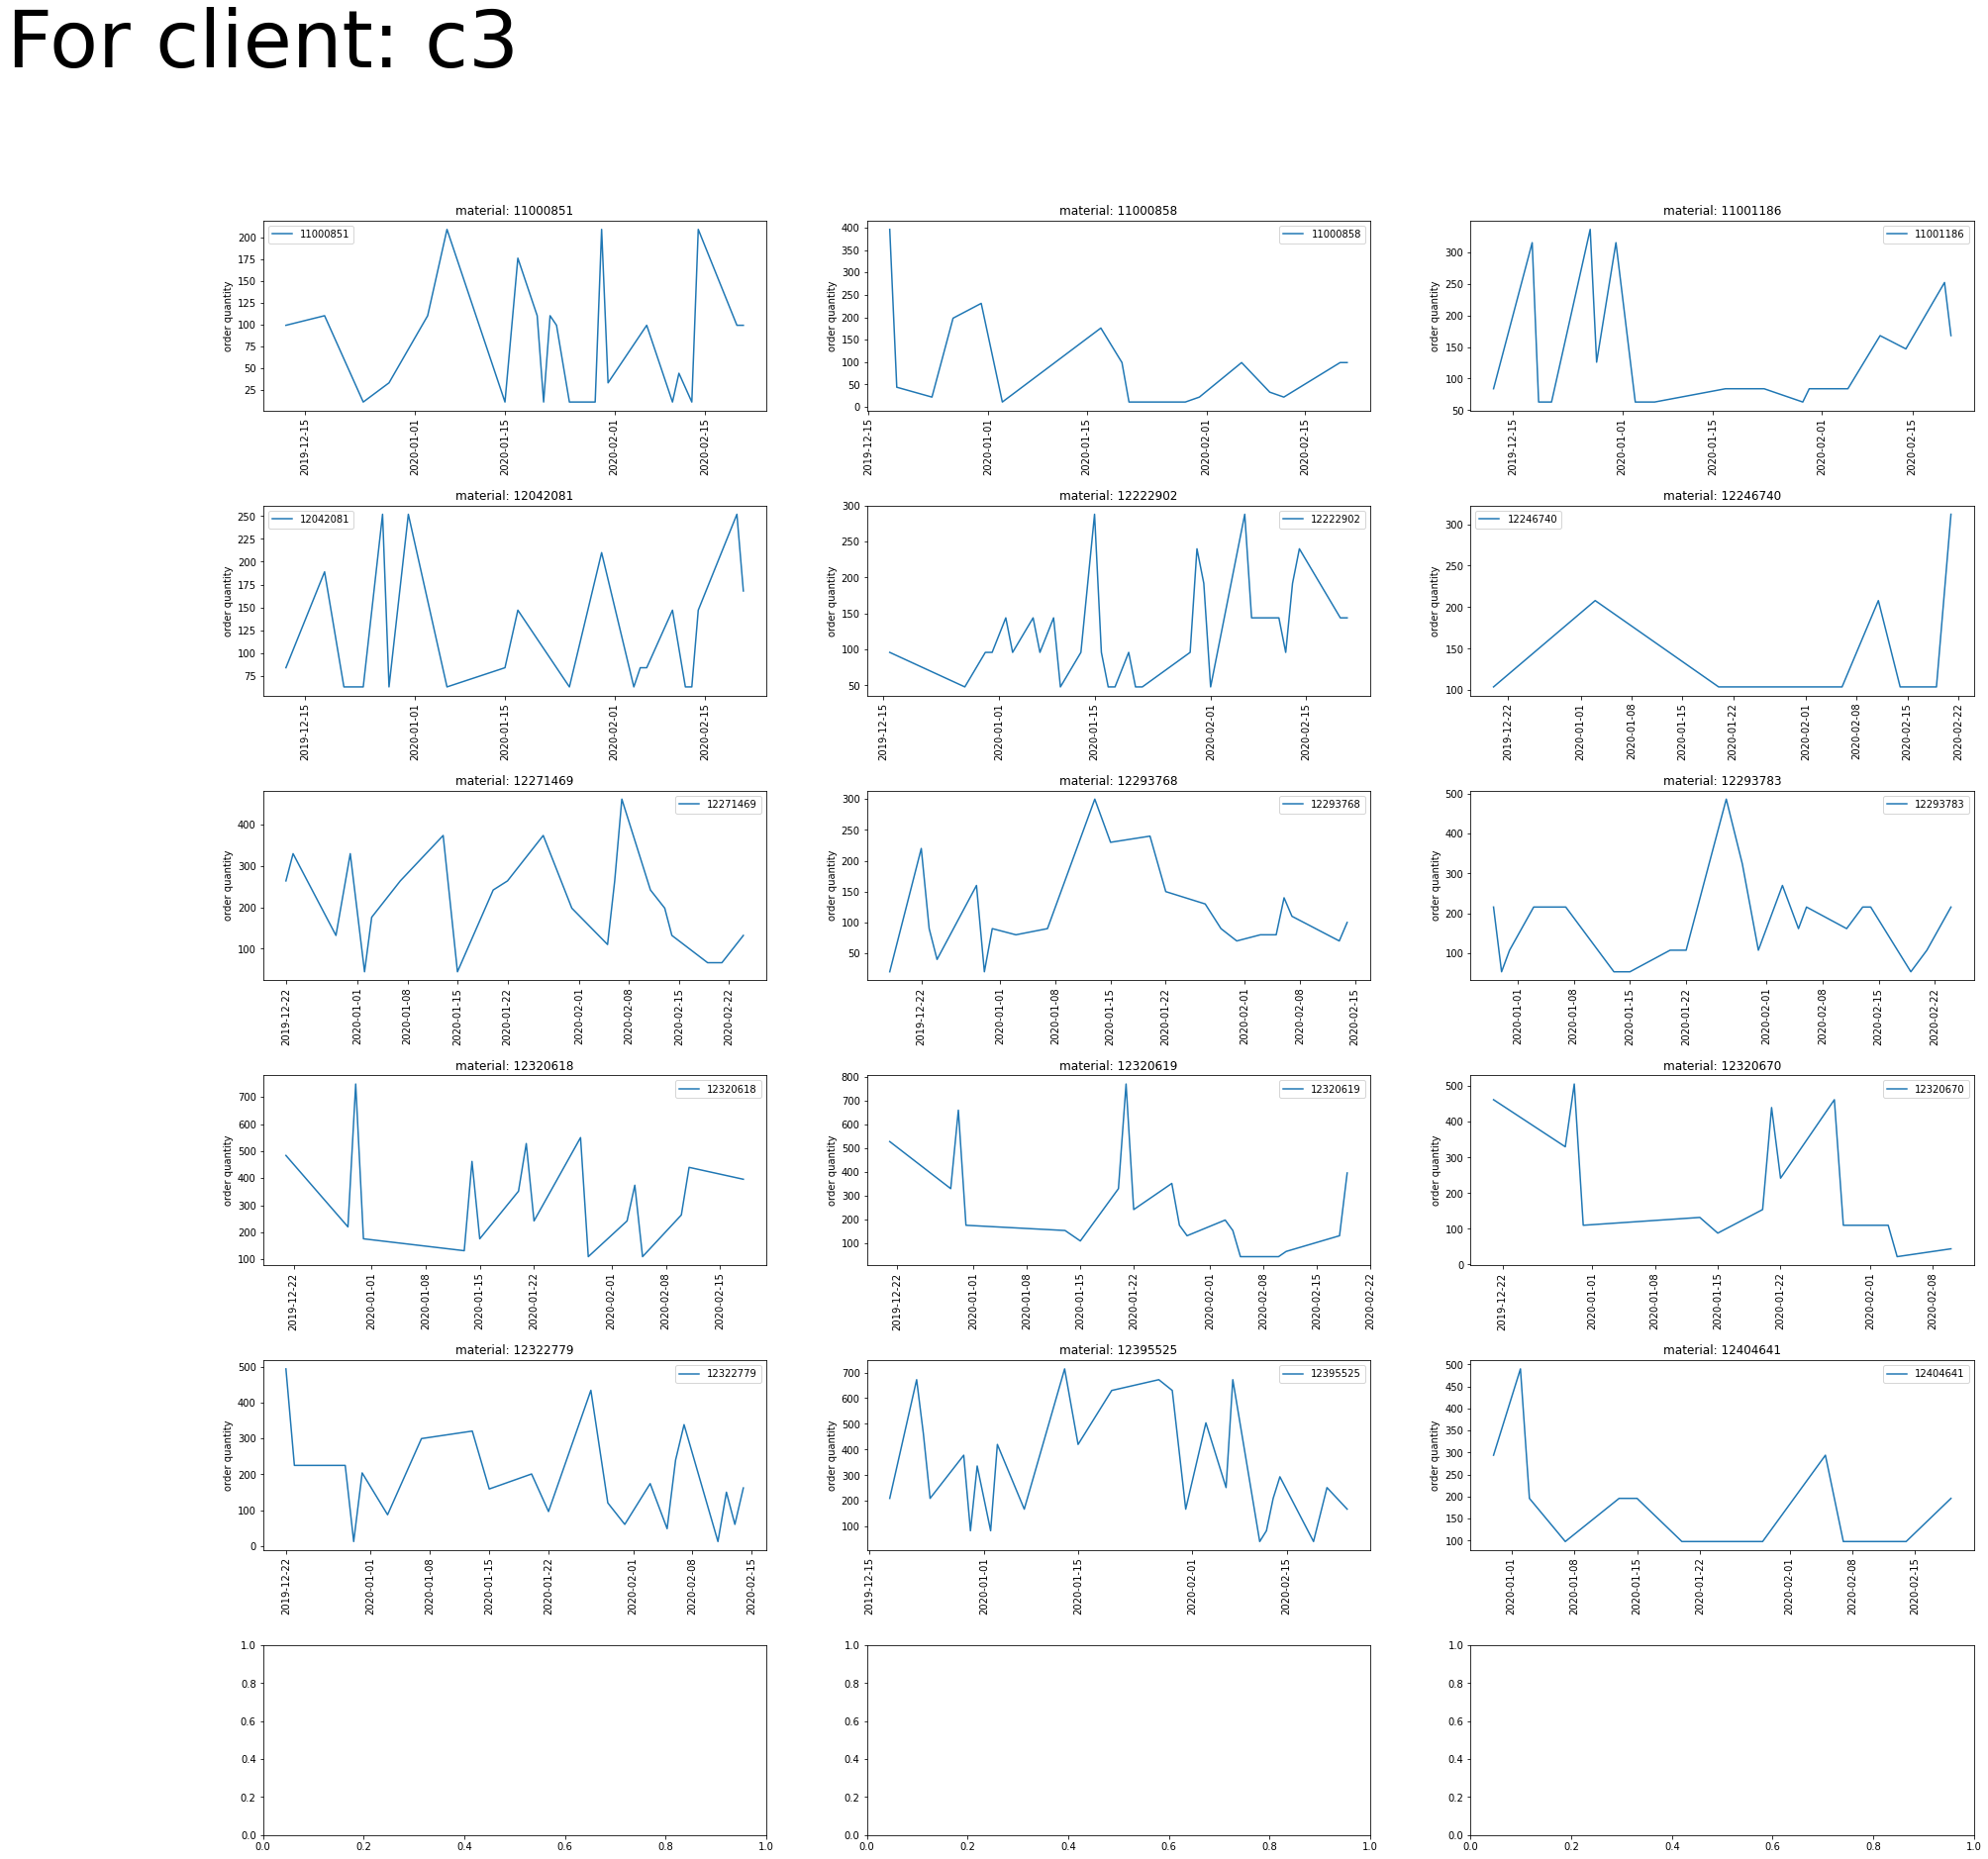

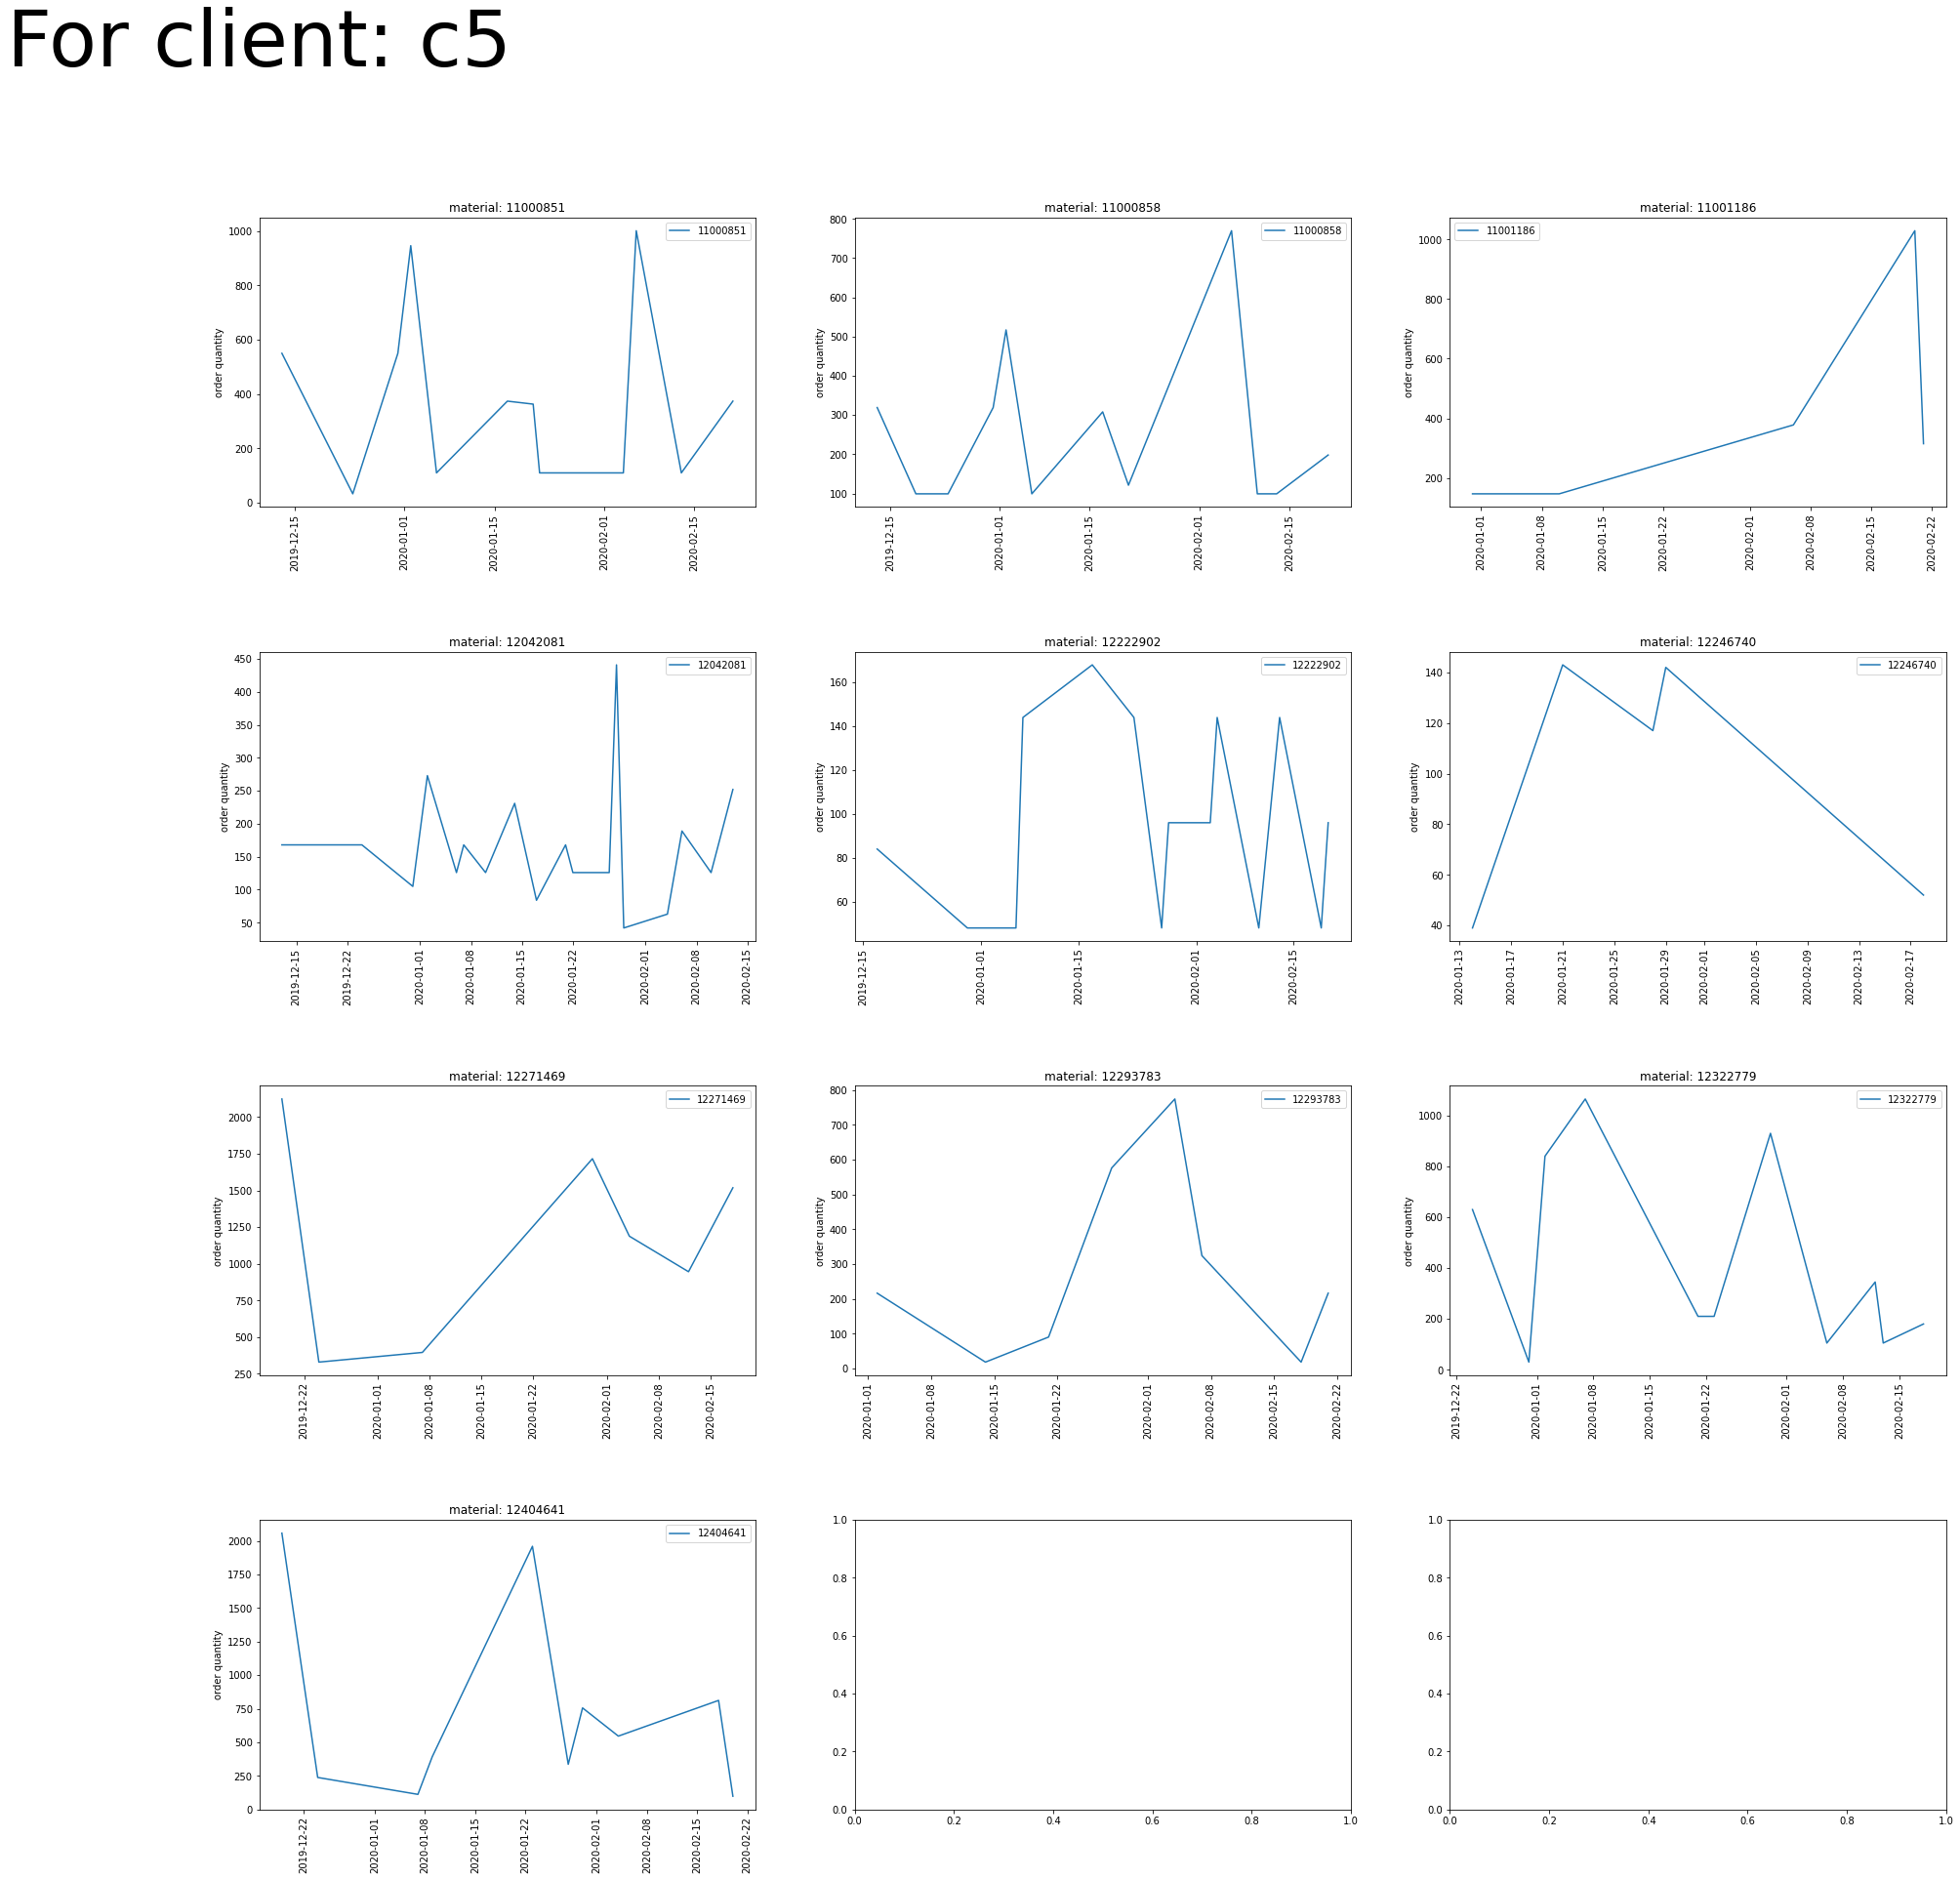

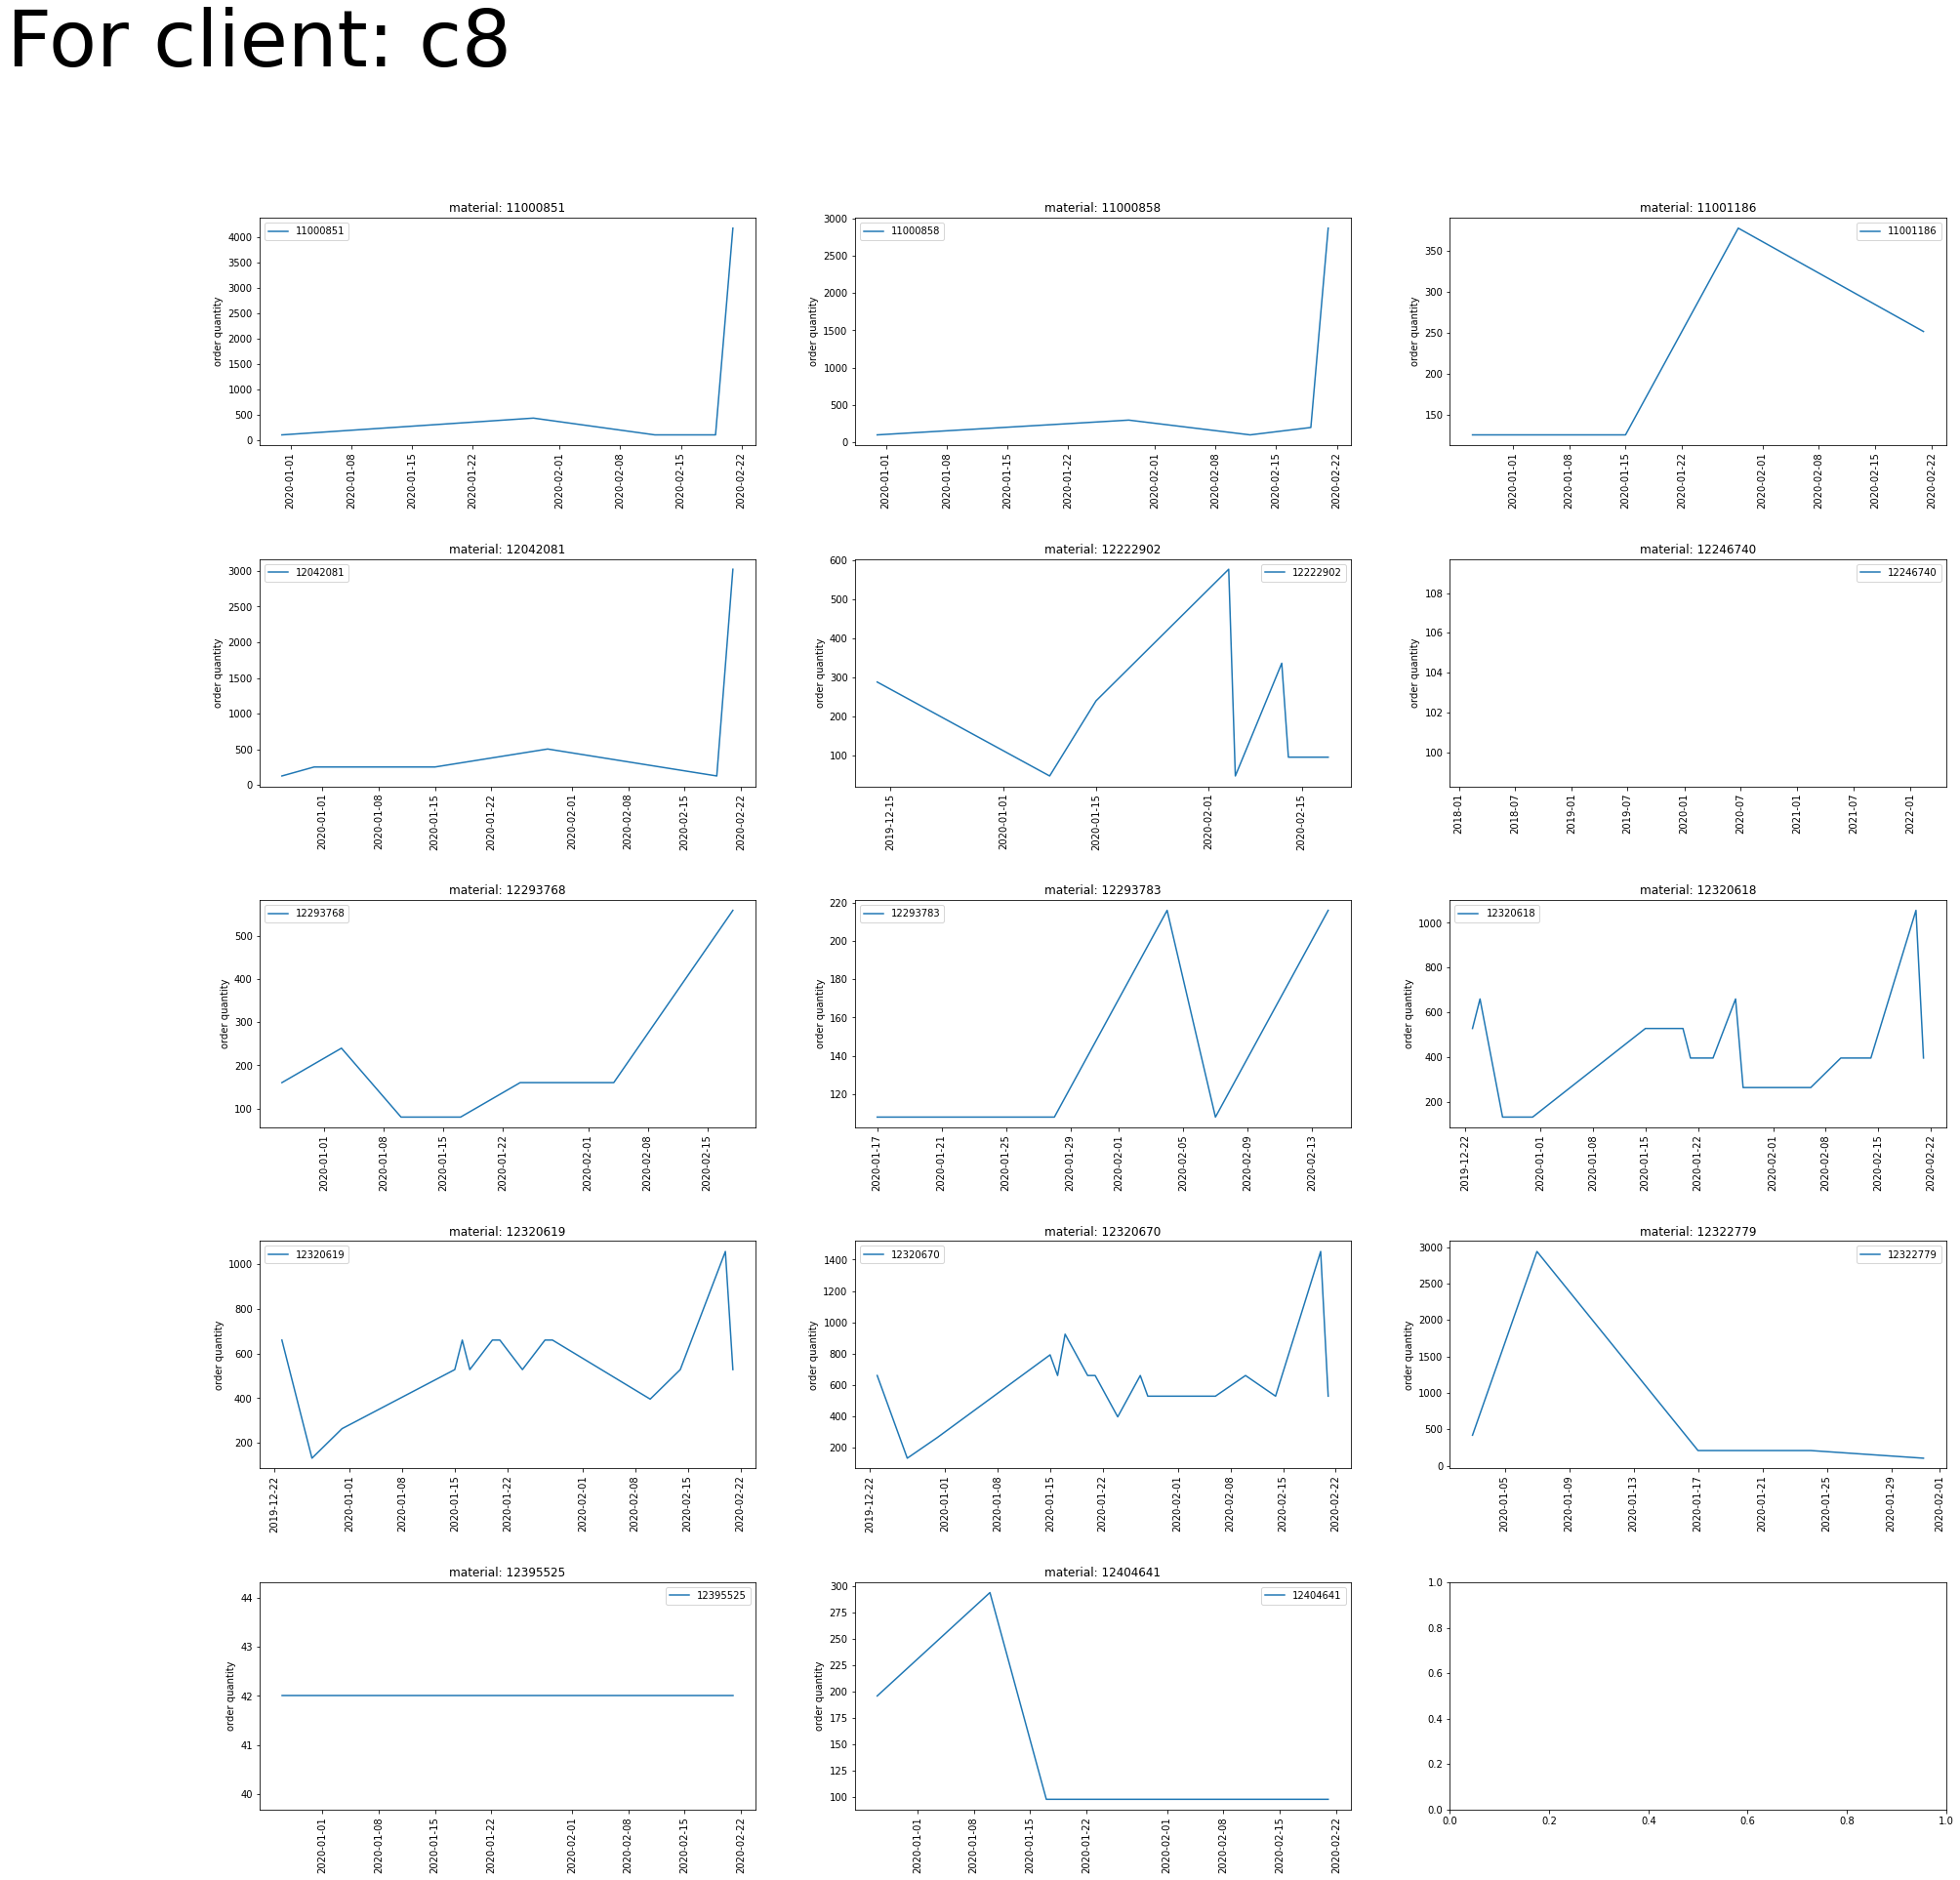

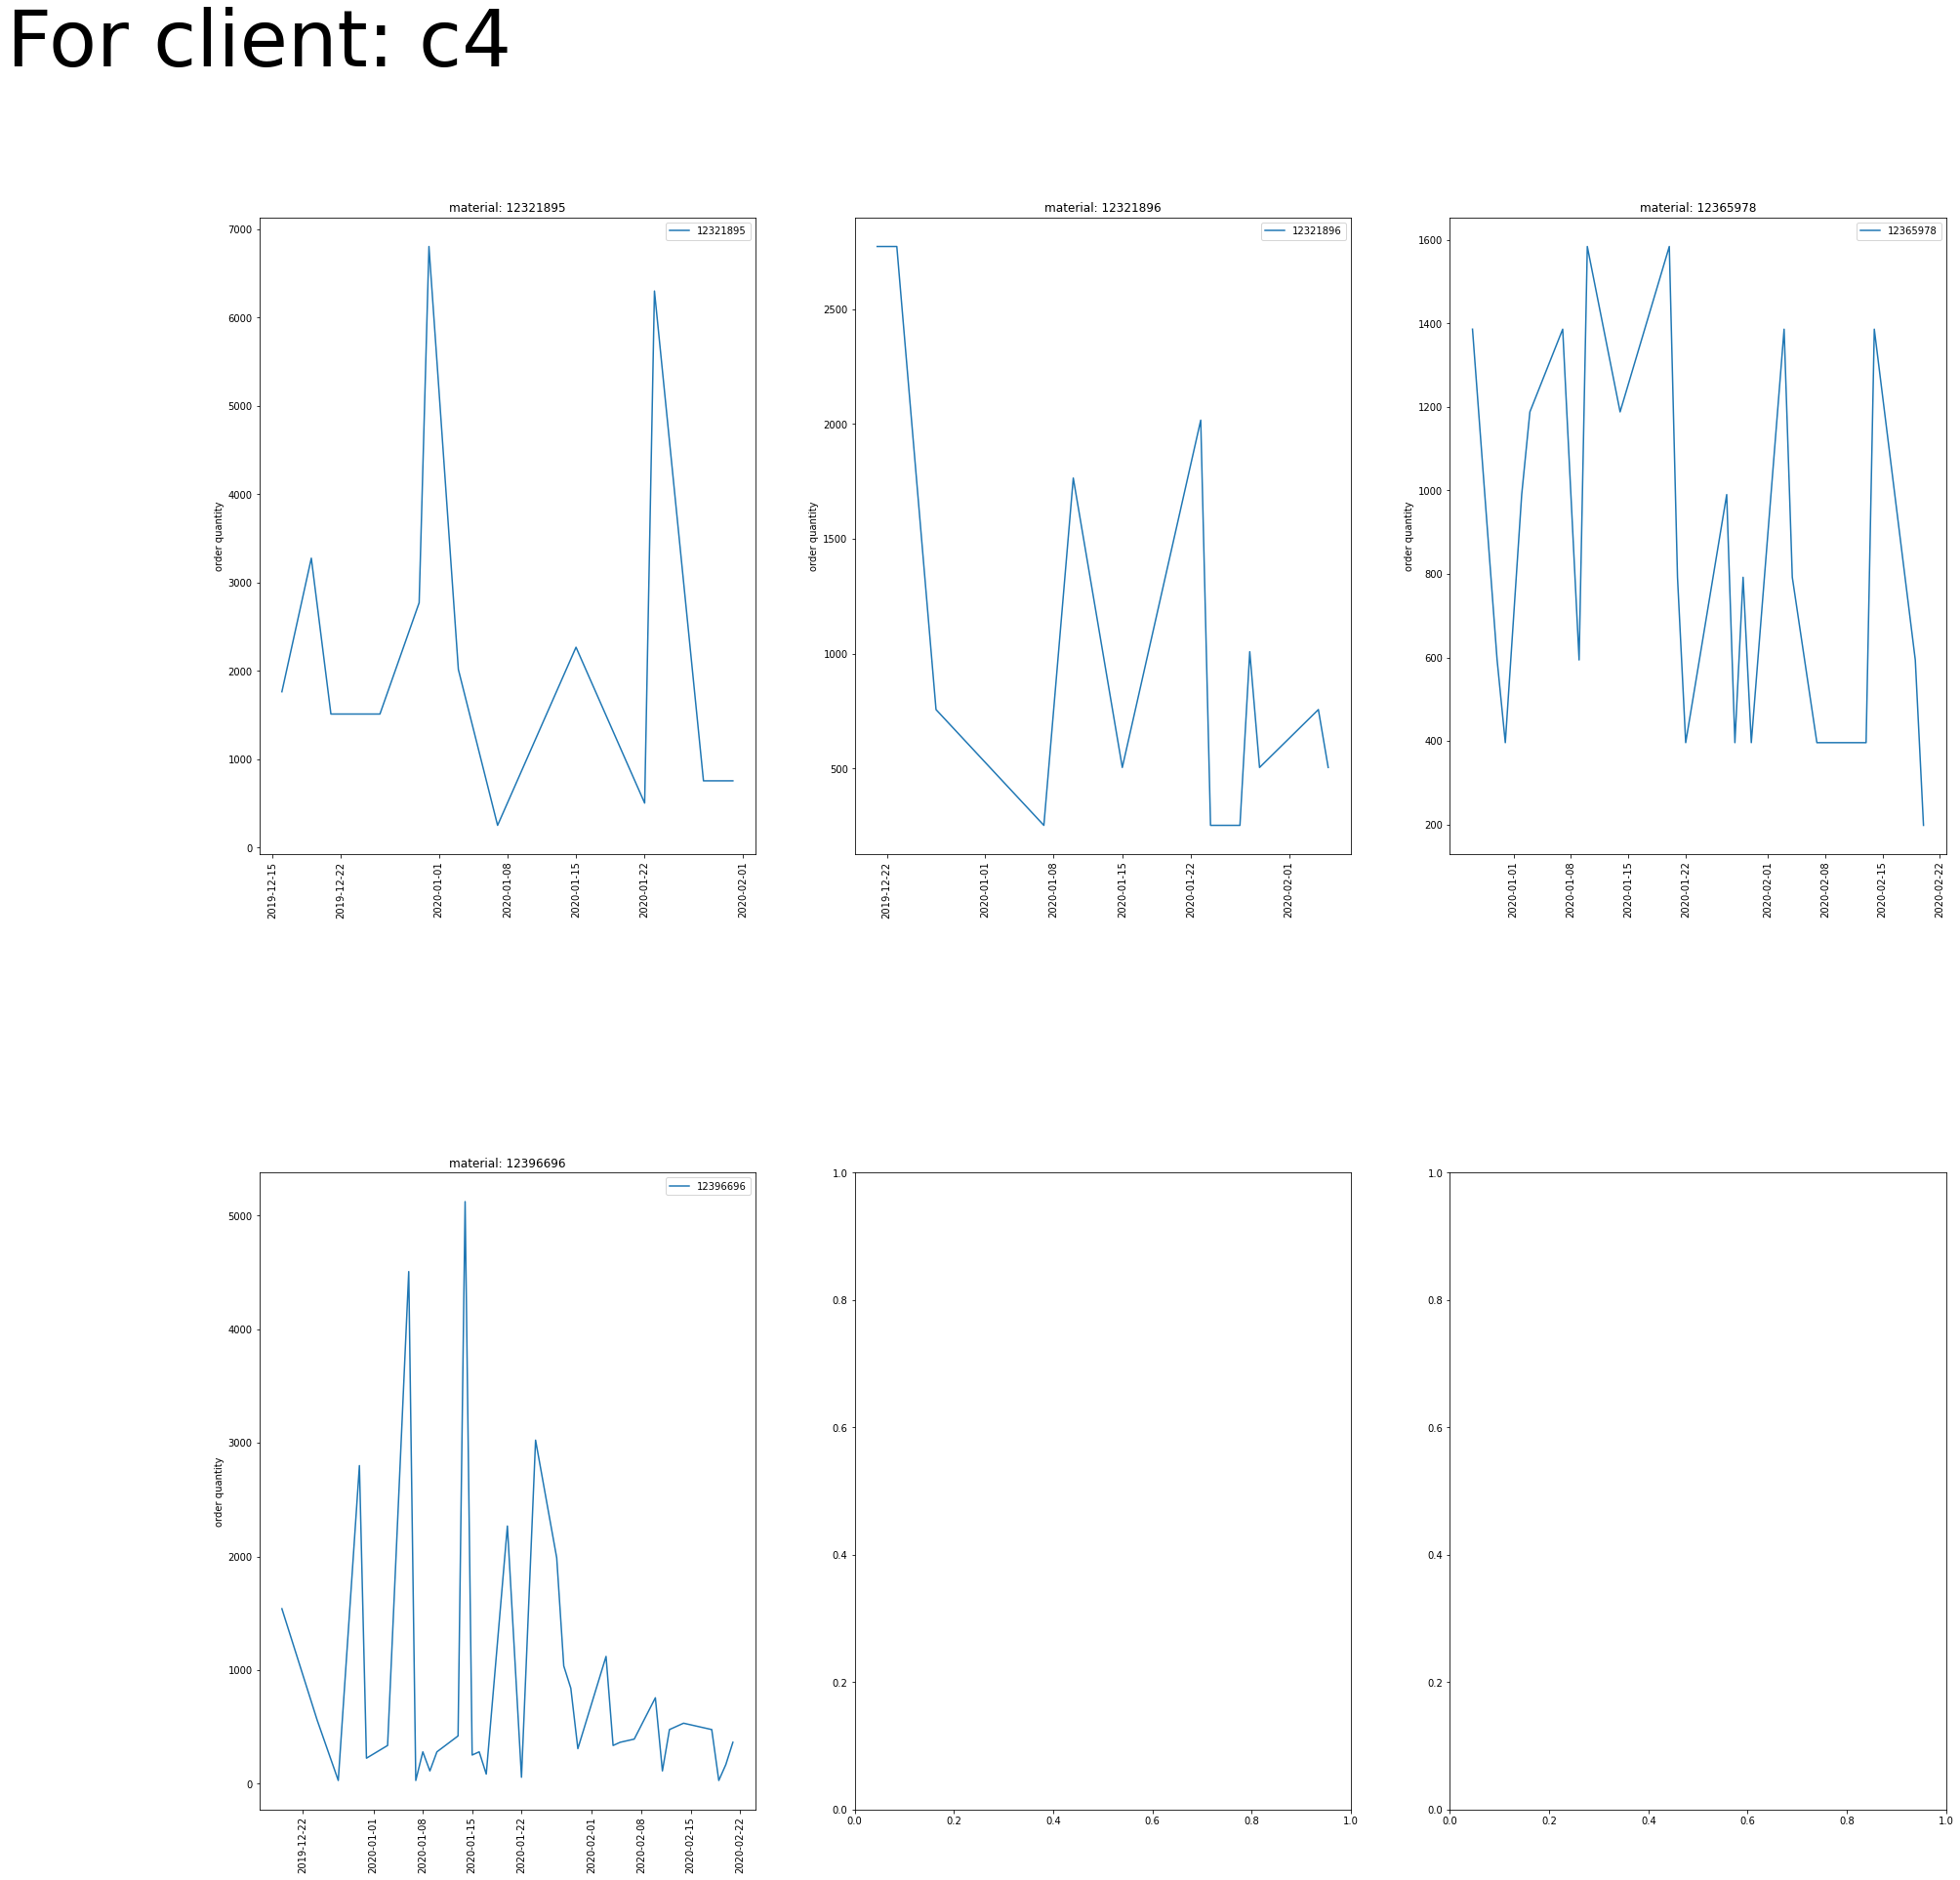

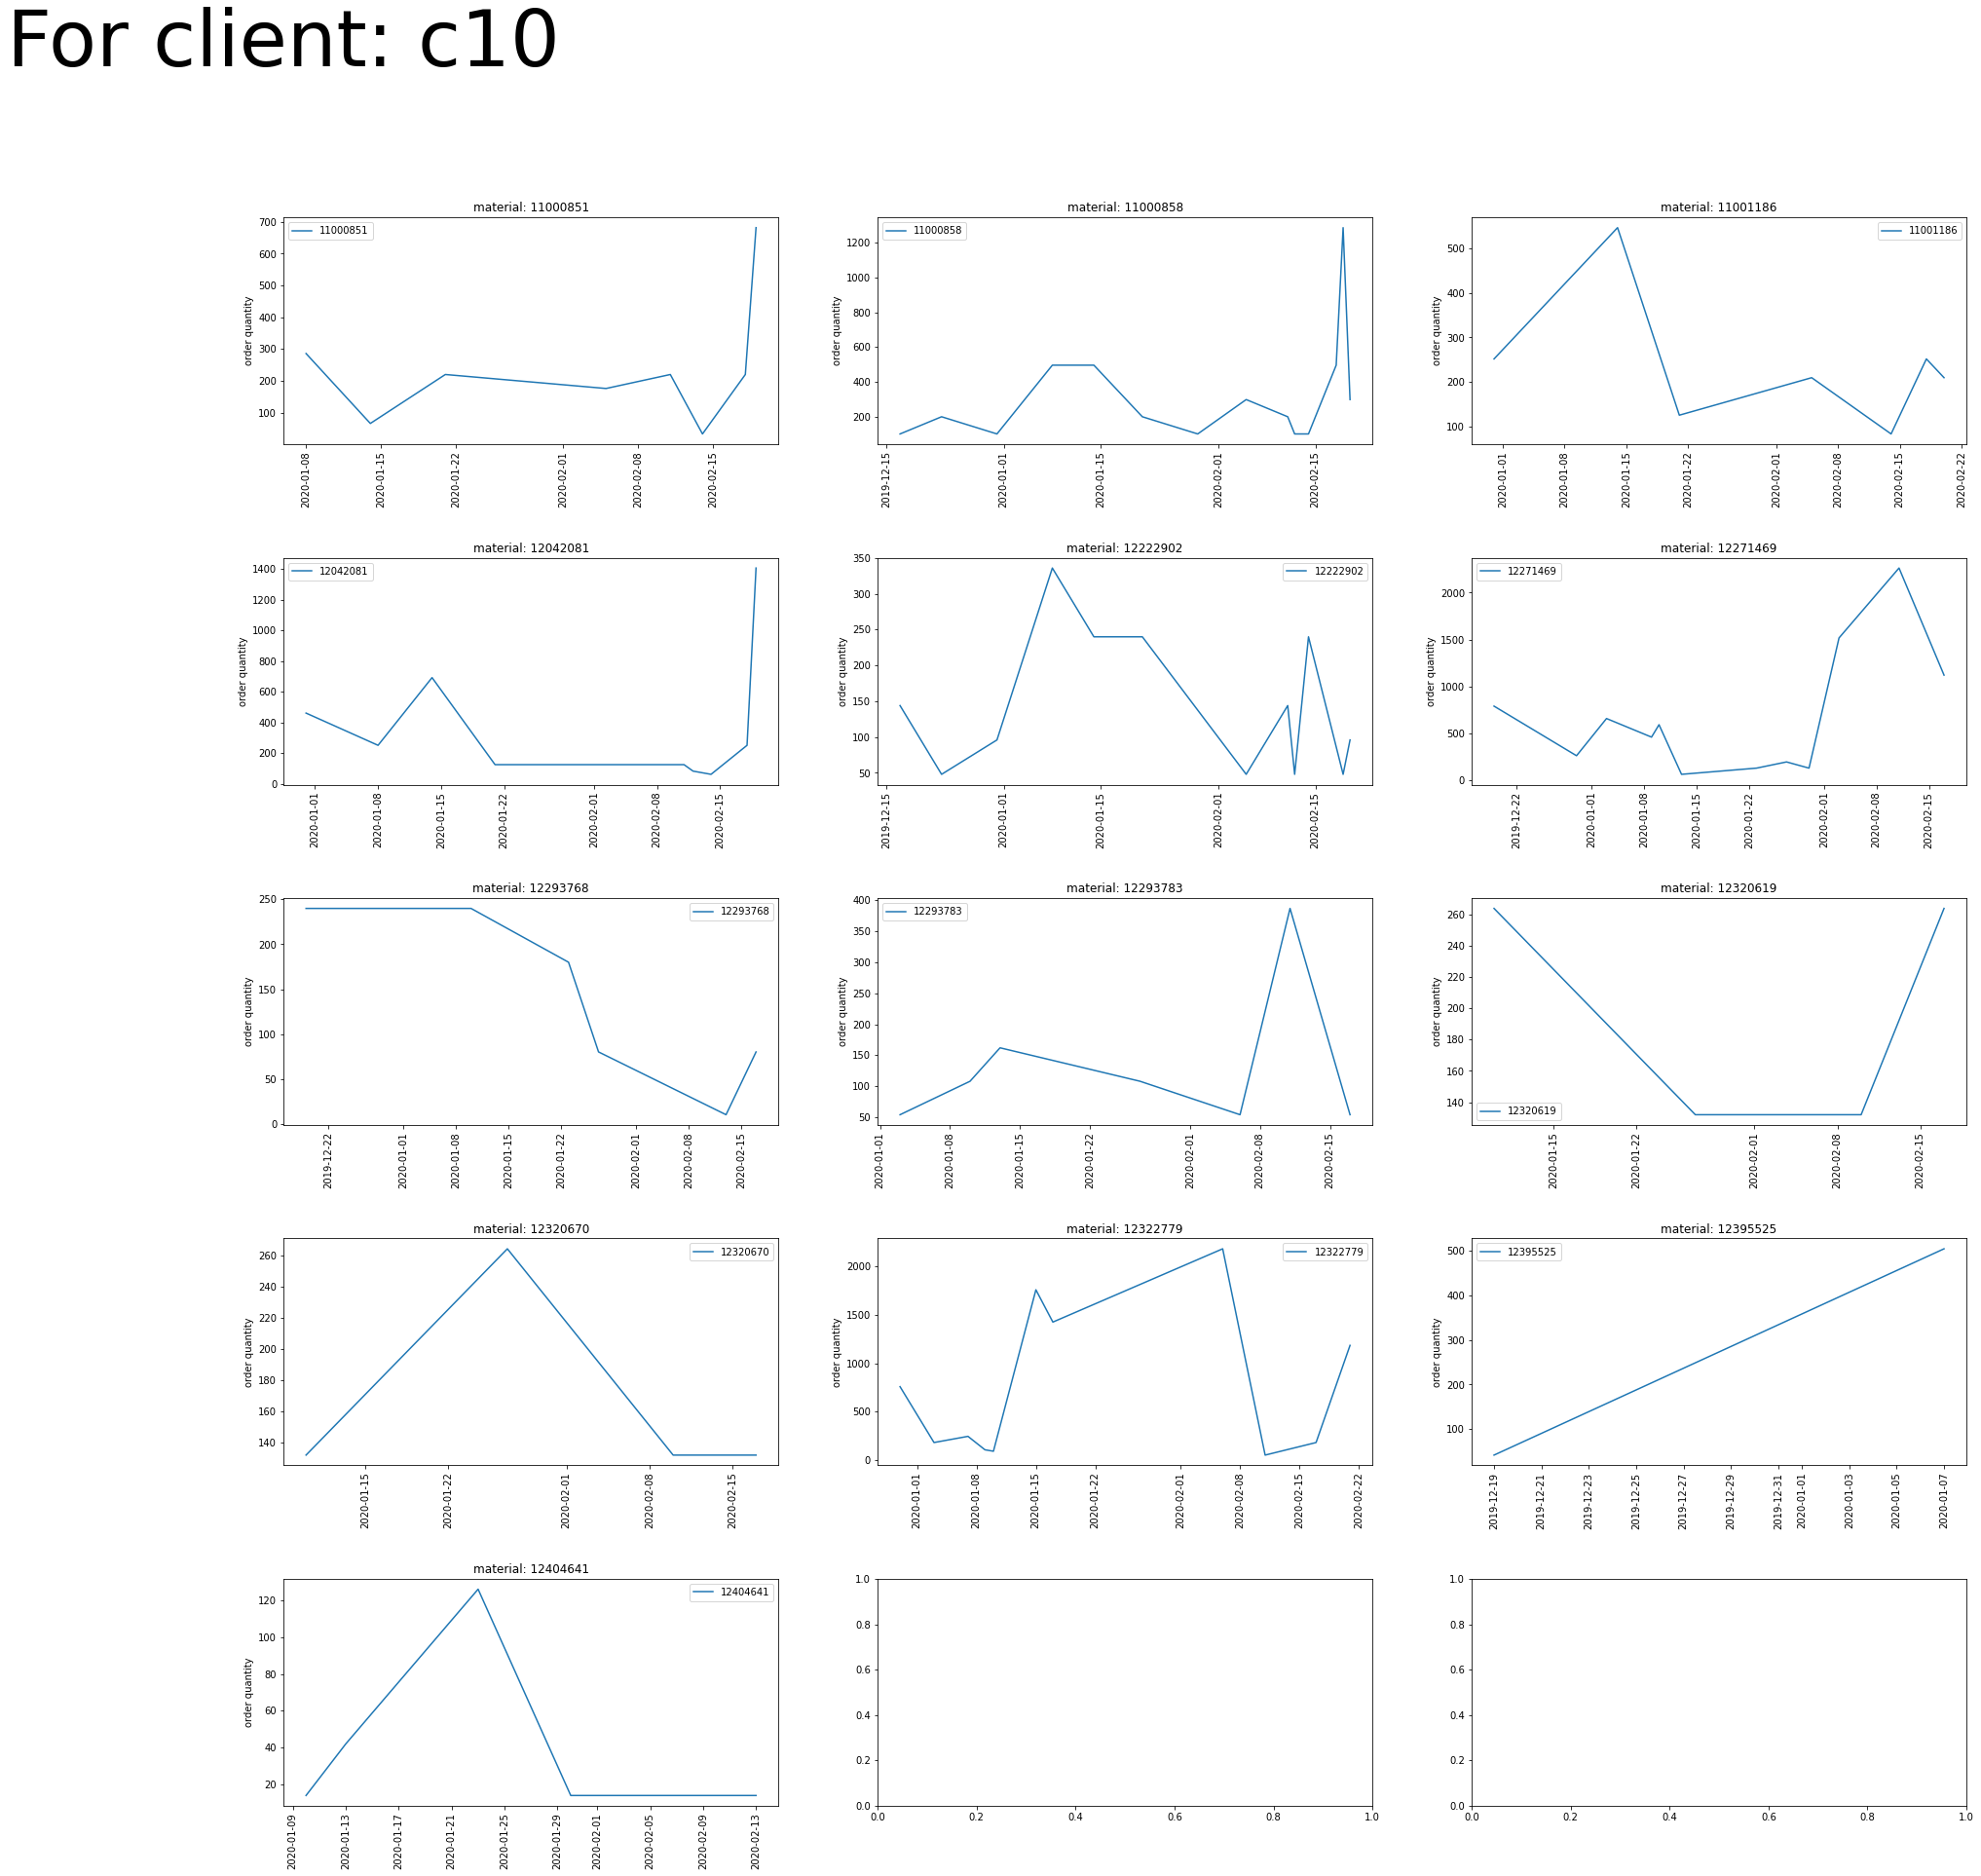

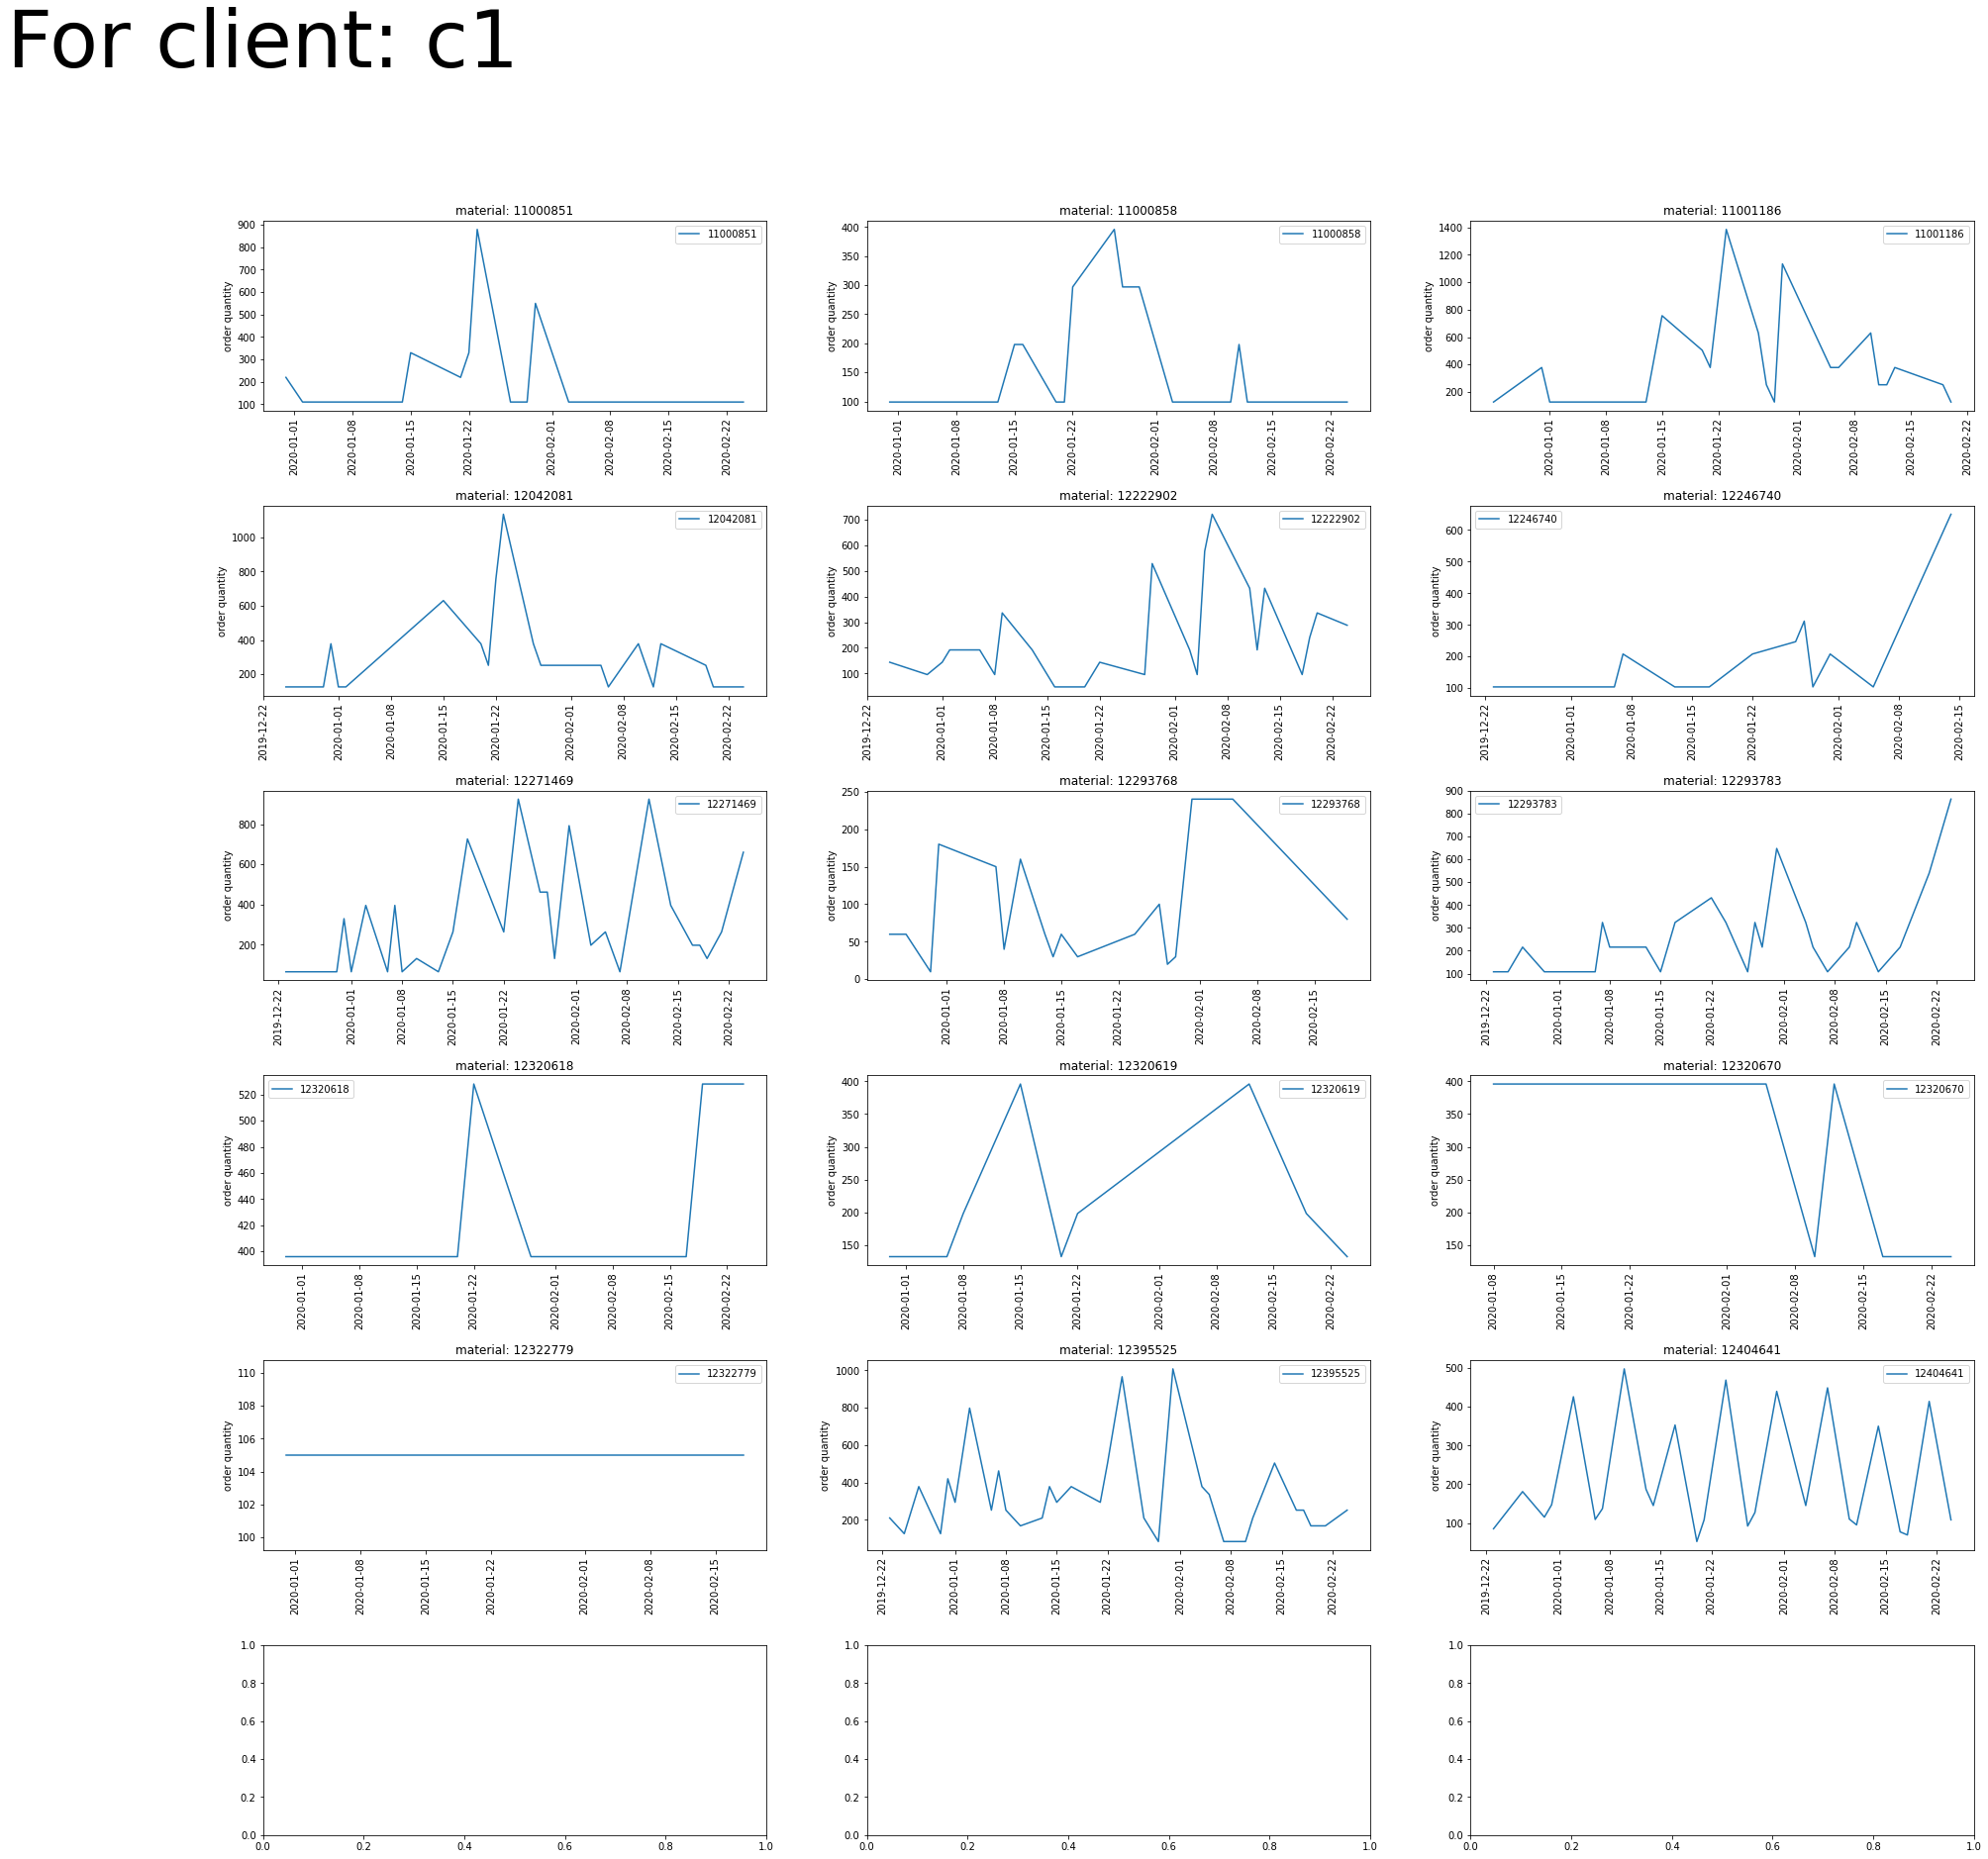

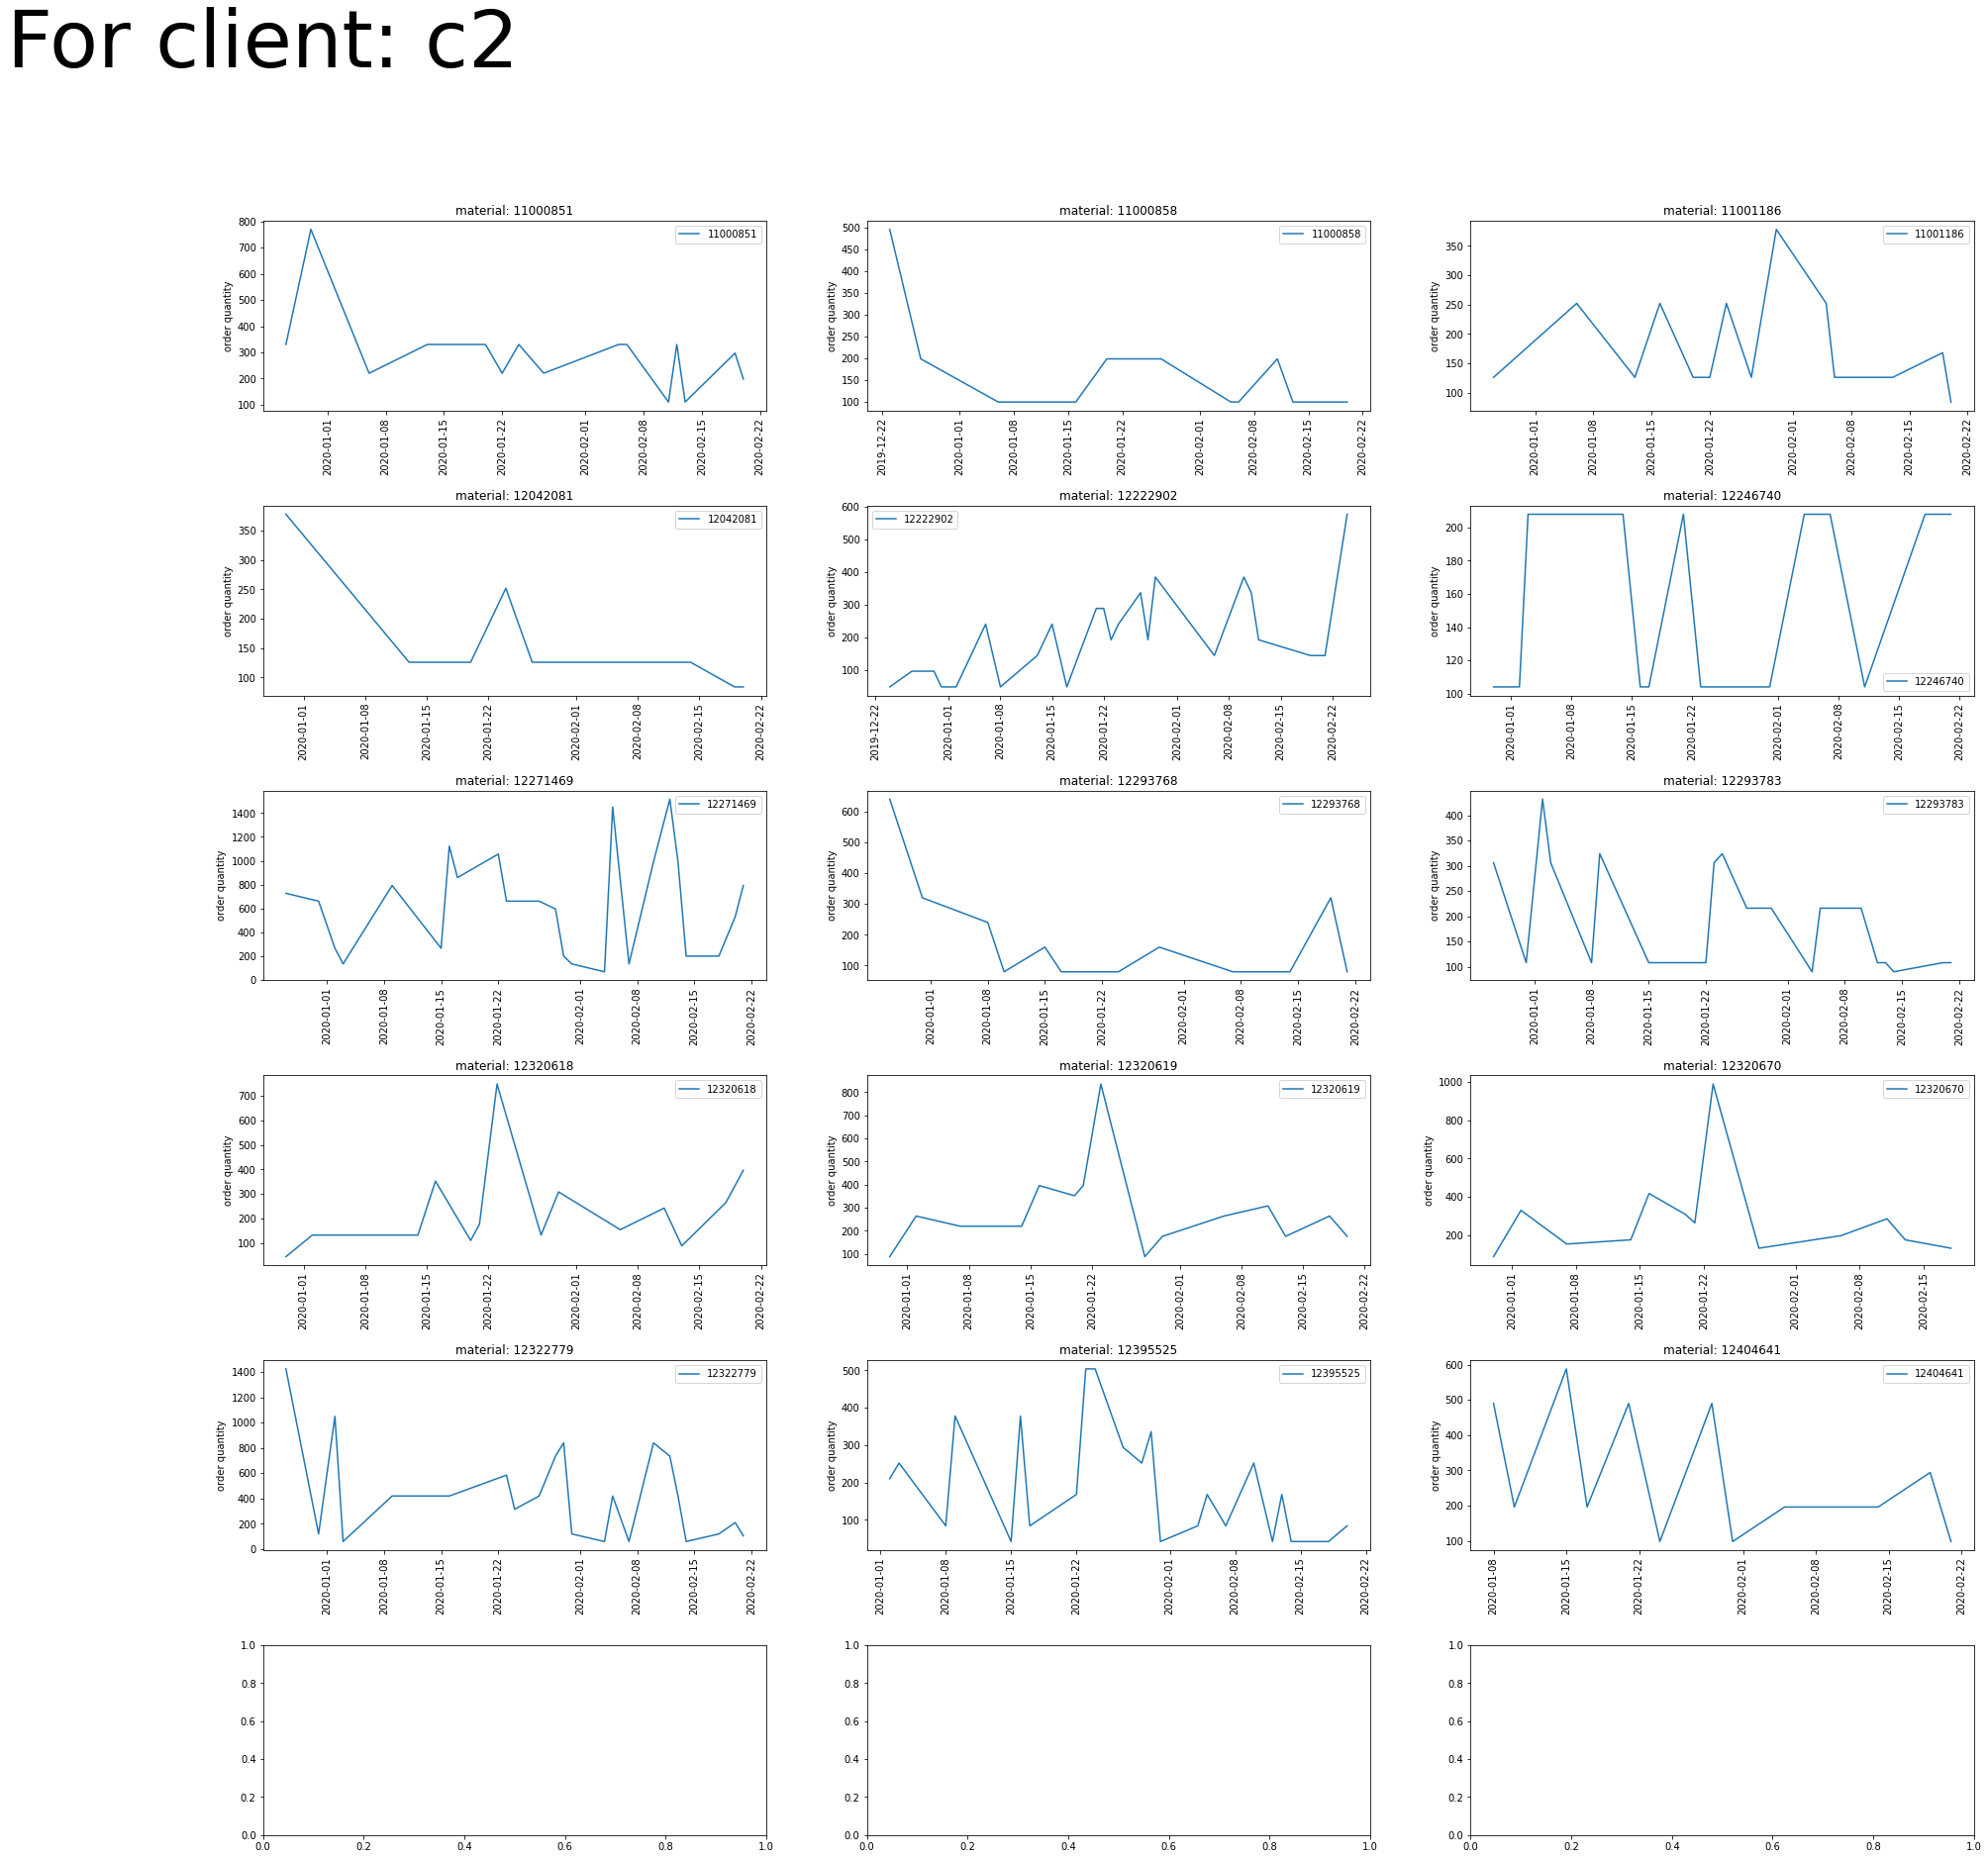

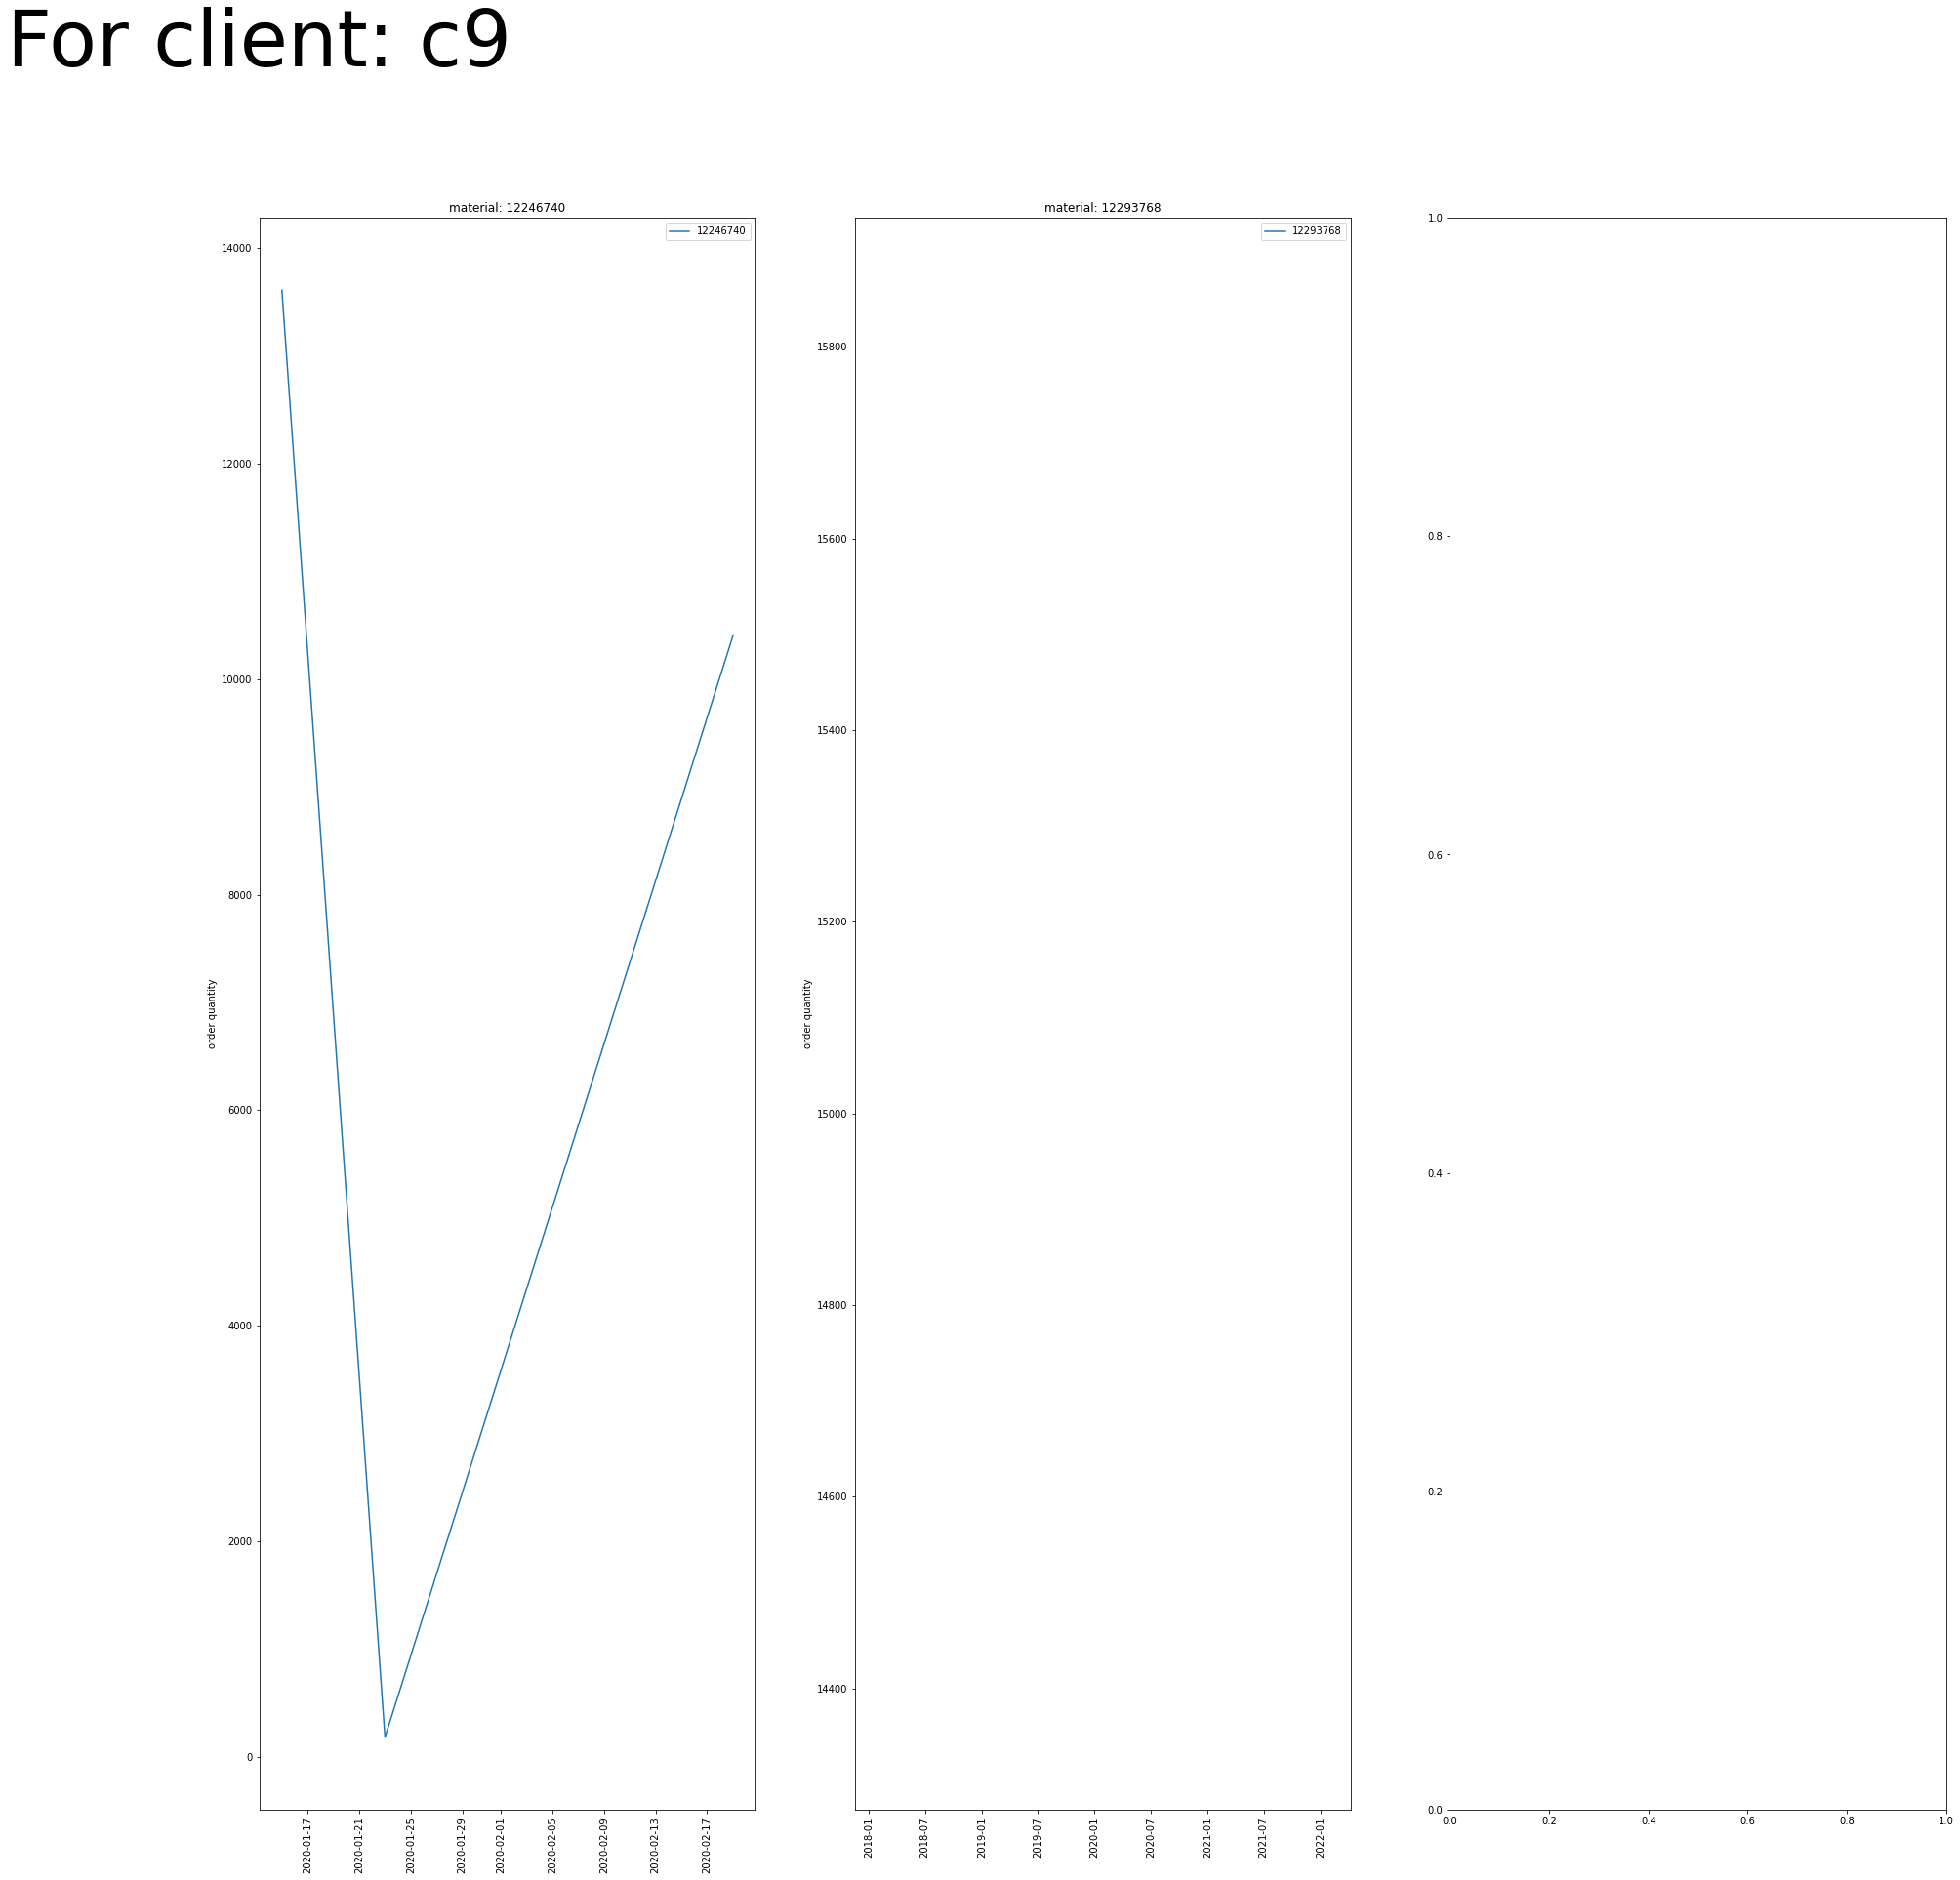

In [ ]:
for name in data_grouped.Client.unique():
  pair_plot(name)

##3. Methods


###3.1. Moving Average (MA)
The moving average (MA) is the first forecasting method we have chosen.  In statistics, a moving average is also called a rolling average or running average. Its application spread in a broad range of areas such as finance, economics, engineering, or math. It is frequently used to analyze data points by calculating a series of averages over different subsets of the whole dataset.  The size of the subset is fixed and chosen by the user in advance. In time series analysis, a moving average is commonly used to smooth out short-term fluctuations and predict longer-term trends. Due to the nature of the moving average method, lags exist between the actual demand and forecasting value. The longer the time period for the moving average, the higher the lag.





There are various types of moving average methods, such as simple moving average, cumulative moving average, weighted moving average, and exponential moving average. In this project, a simple moving average (SMA), which is the unweighted mean of the previous n data, is used to forecast total order quantity on a given date. One of the advantages of using the simple moving average is that applying an SMA could eliminate the variation that if the data set has a periodic fluctuation. However, it requires that the average contains one complete, and a perfectly repetitive cycle rarely exists. On the other hand, one of the disadvantages of using this method is that the size of the average data is too small compared to the full data set. Therefore, unexpected artifacts may happen when there is a sudden change following a smooth line.


In this project, the unweighted mean of the previous three data points is calculated. A built-in function is written in the Python code with a known client and material information, and the date is used as the input. The forecasted total order quantity will be calculated based on the three previous data set. In our case, since some pairs of client and material only have two order numbers on the record, it is unable to forecast using this method. Other than that, both actual and predicted total order quantity vs. time period for each pair of client and material are be plotted and compared on the graph. Take client “c1” and material “12246740” as an example, the predicted order quantity has a three-day lag but a smoother trend compared to the actual demand. The forecast demand for the last three days remains at the highest point on the graph because the demand forecast for Feb 24 is equivalent to the average demand from Feb 21 to Feb 23, yet there is no record on actual demand after Feb 21 for this specific pair. Besides, if the input date is 2020-02-10 using the built-in function, the order prediction can be calculated as 286.0 based on the analysis.

###3.2. Autoregressive Integrated Moving Average (ARIMA)
The second forecasting method uses ARIMA, which stands for the autoregressive integrated moving average. It is one of the popular statistics and econometric models used to conduct time-series predictions. It can provide a decent understanding of the data as well as the prediction of future forecasting.  Besides, it is more powerful to handle evidential and non-stationary datasets than MA (moving average) since its integrating steps can be implemented multiple times to minimize the negative effect on forecasting due to non-stationarity and seasonality. 



The analysis performed using ARIMA is divided into three stages described in its introduction paper, Box and Jenkins(1976)  [[1]](https://dms.umontreal.ca/~duchesne/chap7.pdf). The first stage is identification in which the time-series dataset is statistically analyzed by differencing, checking stationarity, computing autocorrelations, examining the partial autocorrelations, etc. This stage allows the user to have a range of model options for the next step.

In time-series forecasting, an ARIMA model predicts a value as a linear combination of its own past values known as the lags and past errors. Therefore, it does not use any additional features other than the target data itself. Instead, it is specified with three key parameters which are: 
  <ol>
  <li> p - the number of lag observations or the Autoregressive terms (AR)</li>
  <li> q - the size of the moving-average window (MA)</li>
  <li> d - the degree of difference</li> </ol>
While p and q stand for the order of AR terms and MA terms, the d value, which is the degrees of difference, is also critical. This is because using stationary data such that the mean and variance are roughly consistent over the time horizon is very important for time-series forecasting [[2]](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8).  The procedure of differencing the data can effectively smooth out the seasonality and trends which is common in the sales dataset as business activities tend to grow over the years.
 
<p> Therefore, in the second stage of estimation and diagnostic checking, the candidate ARIMA models with different combinations of parameter values are fitted tentatively. According to diagnostic statistics produced in the tests, the user can judge the adequacy of the models and determine the best performing model. Recall from Section 2, we assumed that the time-series data for each pair of client and material is stationary based on data exploration and visualization. Therefore, as we dive straight into the second stage, the group adopted an automated stepwise search method to determine the best ARIMA model with a suite of parameters. With a grid of p, d, and q values, the procedure iterated through each combination of parameters and keep track of the configuration with the reported statistics. For our dataset, we tested p and q starting from 1 while the order of differencing starts at 0.  The model optimization step generates a list of candidate ARIMA models along with the fitting statistics of each model and chooses the best model to proceed. Typically, the values of AIC and BIC are checked for model selection. These two numbers are derived based on the log-likelihood of the model on the training dataset, and the model with the lowest AIC and BIC shows the best performance.   </p> 




For example, with the prepare data for client “c3” and material “12320670”, a list with 9 valid models and their AIC and BIC scores are provided in the output. The model ARIMA(2,0,0) has the lowest AIC which equals 601 and the BIC of 609.473, hence, it will be selected as the most suitable model for the forecasting stage. 

![Example Arima model selection output](https://drive.google.com/file/d/1cQFlwWDfSIwipRTE-ngwmF54c0HRcge_/view?usp=sharing)

##4. Major functions (500~750 words)





###  4.1. Data Cleaning
>The group performed data cleaning on the original dataset since the original dataset is unordered with noise and the data points are also scattered at random intervals between orders. Therefore, in the data cleaning function used in Section 2, we first dropped exact duplicates, which are rows with exactly the same date, client, and order quantity. Secondly, we aggregated multiple orders with different quantities made by the same client for the same material on the same day. The data was then sorted by the date according to its time-series characteristic.


In [ ]:
def clean_data():
  ## Remove exact duplicates
  df.drop_duplicates(keep=False, inplace=True)

  ## Aggregate orders with the same date, client and material but different quantities
  df_grouped = df.groupby(['Date', 'Client', 'Material']).agg({'Order Quantity': ['sum']})
  df_grouped.columns = ['Order Sum']
  df_grouped = df_grouped.reset_index()

  ## Sort the data by date
  df_grouped['Date']=pd.to_datetime(df_grouped['Date'])
  df_grouped = df_grouped.sort_values(by='Date')
  data_grouped = df_grouped.sort_values(by='Date')
  data_grouped.set_index('Date', inplace=True)
  data_grouped.index

  ## Notes: data_grouped is used for visualization and df_grouped is used for forecasting
  df_grouped = df_grouped.reset_index()
  df_grouped.drop('index',inplace=True,axis=1)

  return data_grouped, df_grouped

###  4.2. Interpolation to fill in the missing points
>Since the data points in the subsets do not have a consistent time interval, data interpolation is used to derive from two observed data points used to fill up the missing dates in between.

In [ ]:
def data_interp(client, material): 

  # split dataset by client and material
  df_old = df_grouped[df_grouped['Client']==client]
  df_old = df_old[df_old['Material']==int(material)]

  # create a empty dataset and assign date to the empty dataset
  df_new = pd.DataFrame()
  df_new['Date'] = pd.date_range(start='2019-12-05', end='2020-02-24')

  # join two dataset and interpolate the middle order numbers 
  df_new = df_new.join(df_old.set_index('Date'), on='Date')
  df_new["Order Sum"] = df_new["Order Sum"].interpolate(method = "linear")
  df_new.drop(['Client','Material'],axis=1,inplace=True)

  return df_new

###  4.3. Forecasting with MA
>The simple moving average model predicts the next day order quantity by taking the average from the previous three days.  It will first store its in-sample prediction as ‘ma’. Then, for simplification, a temporary array will be created as a clone of the dataset for selected client and material, and a similar moving average calculation will obtain the future order forecast based on the user input ‘n_period’, which represents the number of period forecasts. By the time the loop finishes, we will have an in-sample prediction array called ‘ma’ and a temporary array with the future order forecast. Then we append the future order forecast value at the end of the temporary array to our prediction array as the final return result. The user will be able to see the entire order forecast trend with the return value of this function.
 

In [ ]:
def pred_ma(client, material, date = None, n_period = 7, plt_show = True): # input client, material, default average = 3 days
  n = 3
  data = data_interp(client, material)

  # calculate moving average
  ma = np.full(n, np.nan)
  for i in range(len(data)-n):
    ma = np.append(ma, sum(data['Order Sum'][i:n+i])/n)

  # forcast for future
  temp = data['Order Sum']
  for i in range(n_period-n):
    temp = np.append(temp, sum(temp[-n:])/n)

  # append future forecast with in-sample prediction
  ma = np.append(ma,temp[-n_period:])

  if plt_show == True:
    plt.figure()
    plt.plot(ma, label='prediction')
    plt.plot(data['Order Sum'], label='actual')
    plt.title('SMA in sample prediction' + ' Client:'+ client+ ' - Material:'+ str(material))
    plt.legend()

  return ma

###  4.4. Forecasting with ARIMA
>There are three different parameters in the ARIMA model, which are p, q, d. To determine the best Arima model that fits our data, we used auto_arima function from padarima. First, the function call the data interpolation function to obtain the desired client and material data, then dropped all NaN value to get it ready for auto_arima. Then the auto_arima model set up to for the following goal: 
- Start iteration of p and q from 1
- Use adftest to determine optimal d value
- No seasonality 

>Then, the function will try to fit multiple Arima models to the dataset and determine the optimal model with the lowest AIC and BIC value. The optimal model will be used for future demand forecast by using ‘model.predict’. As a result, the predicted value will be then returned in the output. 


In [ ]:
# auto arima
def pred_auto_arima(client, material, date=None, n_periods = 7, plt_show = True):
  data = data_interp(client, material)
  data.dropna(inplace=True)
  model = pm.auto_arima(data['Order Sum'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      with_intercept=True)
  p,d,q = model.order
  #print(p,d,q)
  #print(model.summary())
  
  #model.plot_diagnostics()

  if date != None:
    pred_array = model.predict_in_sample()
    pred_index = data['Date']==date
    pred_value = list(compress(pred_array, pred_index))
    print('The order prediction on', date, 'is', pred_value)

  # actual data
  #plt.figure()
  #visual_data(client,material)

  # Forecast
  fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
  index_of_fc = np.arange(data['Date'].index[-1], data['Date'].index[-1]+n_periods)

  # make series for plotting purpose
  fc_series = pd.Series(fc, index=index_of_fc)
  lower_series = pd.Series(confint[:, 0], index=index_of_fc)
  upper_series = pd.Series(confint[:, 1], index=index_of_fc)

  # Plot
  if plt_show == True:
    plt.figure()
    graph  = model.predict_in_sample()
    plt.plot(graph)
    plt.title('ARIMA in Sample Prediction' + ' Client:'+ client+ ' - Material:'+ str(material))
   # plt.plot(ma，label = 'Simple Moving Average')
   # plt.plot(fc_series, color='darkgreen')
   # plt.fill_between(lower_series.index, 
   #                 lower_series, 
   #                 upper_series, 
   #                color='k', alpha=.15)

    #plt.title("Forecast in " + str(n_periods)+ " Days")
  #plt.show()
  return fc_series

###  4.5. Data preparation according to the user’s input
>Next, subsets of data need to be prepared by taking user's inputs regarding the client, material, and forecasting date. In the prepare_output() function, the user will be prompted to enter these information. If the specification of the client is missing, an aggregated dataset with orders from all clients will be prepared for each type of material. On the other hand, orders of all types of materials will be rolled up for each client if the material is not specified. Otherwise, a single subset of data will be generated for the designated pair of clients and material. While the forecasting function need the number of forecasting days as input, the date entered by the user is converted to the desired format in this step as well.   

In [ ]:
def prepare_output():

    forecasting_date = input("\nEnter forcasting date \n(use the format YYYY-MM-DD ):")
    client = input("Enter client name ( use string c1,c2... only; \nif don't specify, input None ):")
    material = input("Enter material ( use only numbers,\nif don't specify, input None ):")
   
    future_date = datetime.strptime(forecasting_date, '%Y-%m-%d').date()
    start_date = datetime.strptime('2020-02-24', '%Y-%m-%d').date()
    date_diff = future_date - start_date
    forecasting_horizon = date_diff.days
    
    if client != 'None' and material != 'None':

      output_ma_series = pred_ma(client, material, date = None, n_period = forecasting_horizon)
      output_ma = output_ma_series[-1]
      output_arima_series = pred_auto_arima(client, material, date = None, n_periods = forecasting_horizon)
      output_arima = output_arima_series.iloc[-1]
      df_output = pd.DataFrame({'Client': client, 'Material': material, 'Prediction of Moving Average': output_ma, 'Prediction of ARIMA': output_arima}, index = [0])
      return df_output

    if client == 'None' and material != 'None':

      df_material = data_grouped[data_grouped.Material == int(material)]
      output_ma = []
      output_arima = []
      client_name = []
      material_code = []
      for client1 in df_material.Client.unique():
        output_ma1_series = pred_ma(client1, material, date = None, n_period = forecasting_horizon)
        output_ma1 = output_ma1_series[-1]
        output_arima1_series = pred_auto_arima(client1, material, date = None, n_periods = forecasting_horizon)
        output_arima1 = output_arima1_series.iloc[-1]
        output_ma.append(output_ma1)
        output_arima.append(output_arima1)
        client_name.append(client1)
        material_code.append(material)
      
      df_output = pd.DataFrame({'Client': client_name, 'Material': material_code, 'Prediction of Moving Average': output_ma, 'Prediction of ARIMA': output_arima})
      return df_output
    
    if client != 'None' and material =='None':

      df_client = data_grouped[data_grouped.Client == client]
      output_ma = []
      output_arima = []
      client_name = []
      material_code = []
      for material1 in df_client.Material.unique():
        output_ma1_series = pred_ma(client, material1, date = None, n_period = forecasting_horizon)
        output_ma1 = output_ma1_series[-1]
        output_arima1_series = pred_auto_arima(client, material1, date = None, n_periods = forecasting_horizon)
        output_arima1 = output_arima1_series.iloc[-1]
        output_ma.append(output_ma1)
        output_arima.append(output_arima1)
        material_code.append(material1)
        client_name.append(client)

      df_output = pd.DataFrame({'Client': client_name, 'Material': material_code, 'Prediction of Moving Average': output_ma, 'Prediction of ARIMA': output_arima})  
      return df_output

##5. How to use (users’ perspective) (250~300 words)

In this section,  a comprehensive user's guide on how to make a demand forecast with our tool will be provided. Before performing the following list of forecasting steps, the user needs to execute the setup functions in Section 1 and all major functions defined in Section 4.


#####<center></center>
>Step1:  It is required to first perform data cleaning by executing the following line of code 

In [ ]:
clean_data()

(           Client  Material  Order Sum
 Date                                  
 2019-12-05     c7  12222902         72
 2019-12-05     c7  12042081        504
 2019-12-05     c7  11001186        504
 2019-12-05     c7  11000858        297
 2019-12-05     c7  11000851        660
 ...           ...       ...        ...
 2020-02-24     c3  12395525        168
 2020-02-24     c1  12404641        108
 2020-02-24     c1  12320670        132
 2020-02-24     c1  12042081        126
 2020-02-24     c1  11000858         99
 
 [1546 rows x 3 columns],            Date Client  Material  Order Sum
 0    2019-12-05     c7  12222902         72
 1    2019-12-05     c7  12042081        504
 2    2019-12-05     c7  11001186        504
 3    2019-12-05     c7  11000858        297
 4    2019-12-05     c7  11000851        660
 ...         ...    ...       ...        ...
 1541 2020-02-24     c1  12271469        660
 1542 2020-02-24     c1  12222902        288
 1543 2020-02-24     c1  11000851        110
 15

#####<center></center>
>Step2:  By running the next line, the user will be requested to enter a client ID, a material code, and the target forecast date. While the date is the required information, the entry of either one of the client or material could be blank, however, cannot be both empty at the same time. 

>The output is a dataframe that includes the prediction for the target date from both Simple Moving Average method and Autoregressive Integrated Moving Average model.


#####<center></center>
Three sets of examples are provided as following to explain how to use the above code. Firstly, taking a set of input with client “c7”, material not specified, and target date “2020-02-28”  as an example,  the output will provide the prediction as follows. The dataframe obtained from output contains forecasted demand for all fifteen material required for client c7 using both SMA and ARIMA method. It could be observed that the results from ARIMA prediction are generally greater than those from SMA prediction. 



Enter forcasting date 
(use the format YYYY-MM-DD ):2020-02-28
Enter client name ( use string c1,c2... only; 
if don't specify, input None ):c7
Enter material ( use only numbers,
if don't specify, input None ):None
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=901.407, BIC=911.034, Time=0.069 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1037.097, BIC=1041.911, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=900.237, BIC=907.457, Time=0.072 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=968.842, BIC=976.062, Time=0.064 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1110.670, BIC=1113.076, Time=0.007 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=901.402, BIC=911.029, Time=0.094 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=903.399, BIC=915.433, Time=0.114 seconds
Total fit time: 0.434 seconds
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [inter

Client  Material  Prediction of Moving Average  Prediction of ARIMA
0      c7  12222902                         120.0           130.571336
1      c7  12042081                         378.0           376.383595
2      c7  11001186                         126.0           232.826248
3      c7  11000858                          99.0           156.401065
4      c7  11000851                         220.0           310.541692
5      c7  12404641                         196.0           213.246619
6      c7  12322779                          75.0           429.430767
7      c7  12271469                         341.0           572.939425
8      c7  12246740                          65.0            64.999996
9      c7  12293783                         108.0           153.845664
10     c7  12320618                         132.0           302.035973
11     c7  12320619                         176.0           293.776352
12     c7  12320670                         176.0           284.533769
13     c7  12160666                         105.0           104.999996
14     c7  12293768                          10.0           106.450031

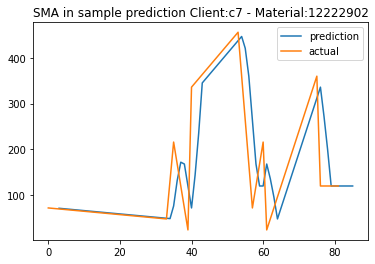

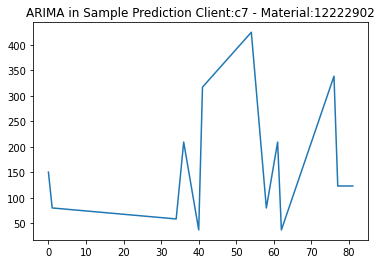

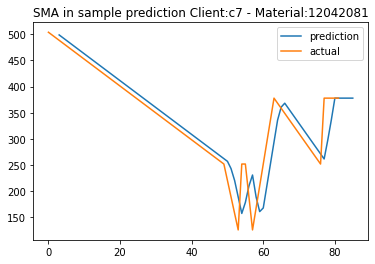

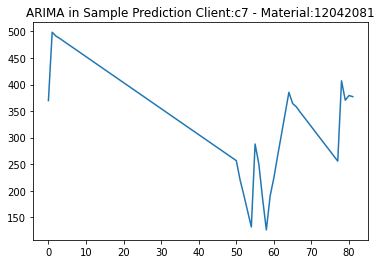

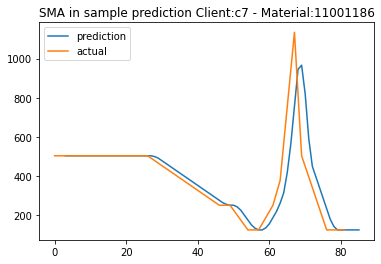

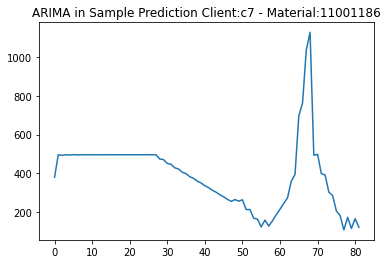

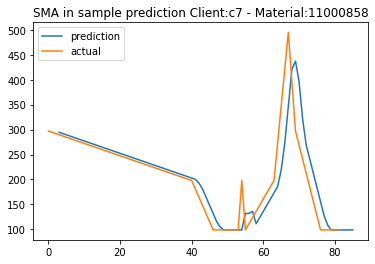

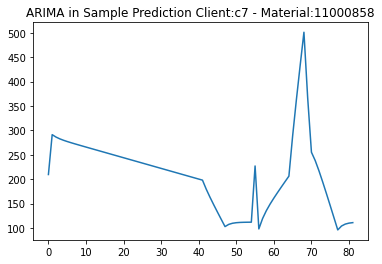

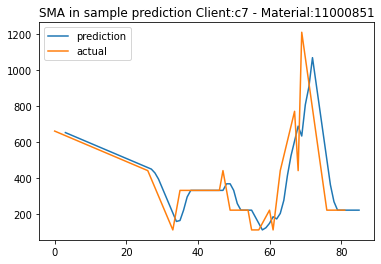

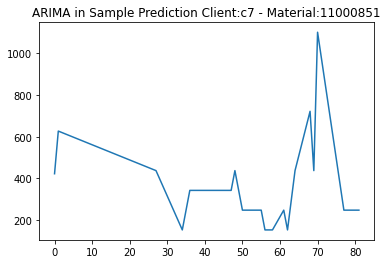

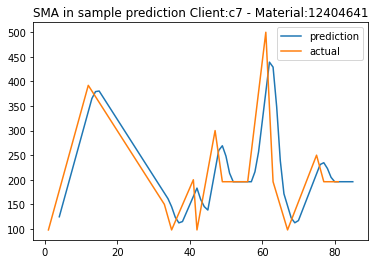

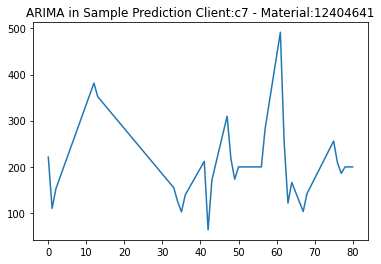

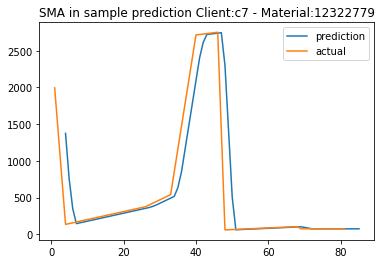

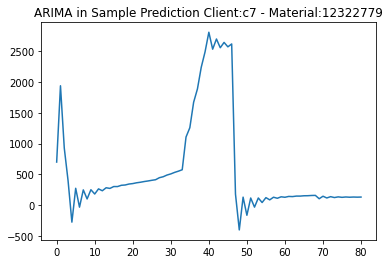

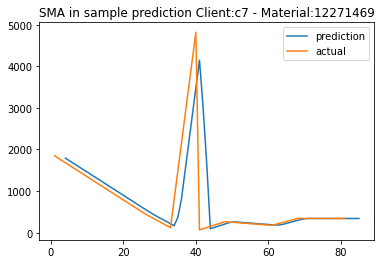

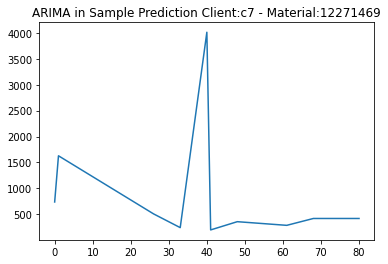

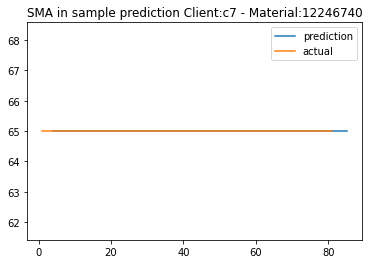

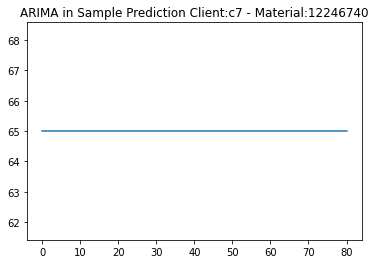

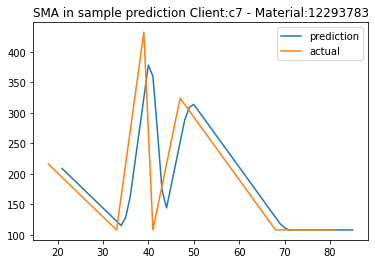

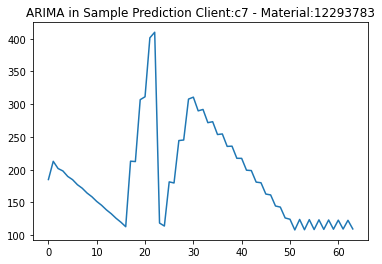

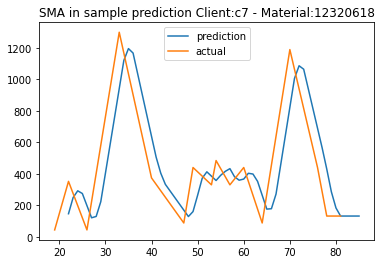

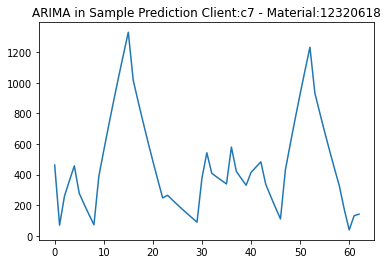

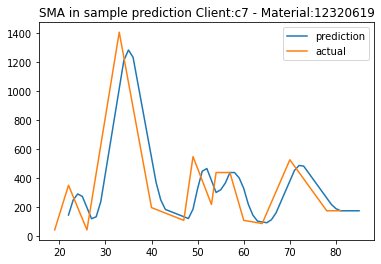

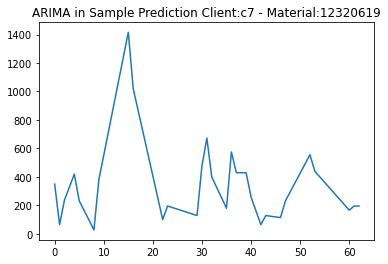

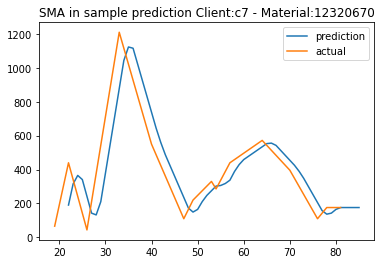

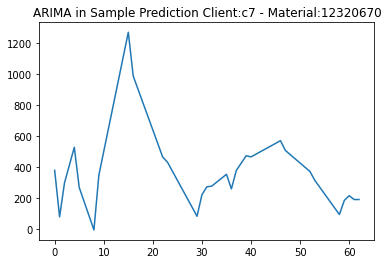

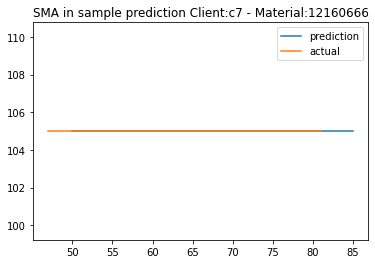

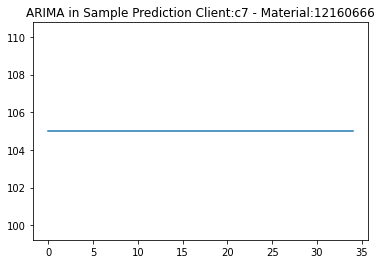

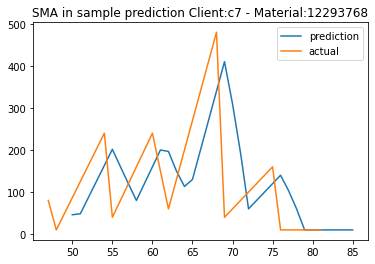

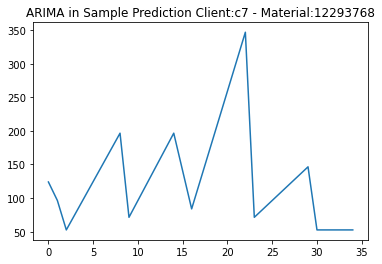

In [ ]:
prepare_output()

#####<center></center>
Another example shows that if material is specified as "12222902" and the client ID is known as "c7", still targeting the date of "2020-02-28", the output is as the following. The resulting predictions from both SMA and ARIMA match the first example.


Enter forcasting date 
(use the format YYYY-MM-DD ):2020-02-28
Enter client name ( use string c1,c2... only; 
if don't specify, input None ):c7
Enter material ( use only numbers,
if don't specify, input None ):12222902
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=901.407, BIC=911.034, Time=0.069 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1037.097, BIC=1041.911, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=900.237, BIC=907.457, Time=0.066 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=968.842, BIC=976.062, Time=0.053 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1110.670, BIC=1113.076, Time=0.011 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=901.402, BIC=911.029, Time=0.096 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=903.399, BIC=915.433, Time=0.122 seconds
Total fit time: 0.431 seconds


Client  Material  Prediction of Moving Average  Prediction of ARIMA
0     c7  12222902                         120.0           130.571336

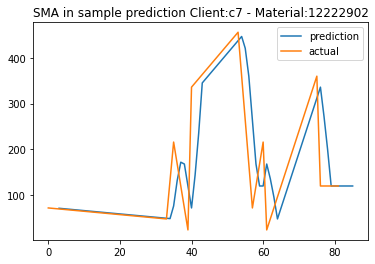

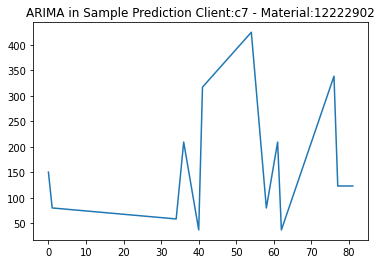

In [ ]:
prepare_output()

#####<center></center>
The last example presents predicted demand for material 12222902 on the date of 2020-02-28 without specifying certain client ID. And the results shows eight different potential client. Again, same forecasted demand happens for client c7. 


Enter forcasting date 
(use the format YYYY-MM-DD ):2020-02-28
Enter client name ( use string c1,c2... only; 
if don't specify, input None ):None
Enter material ( use only numbers,
if don't specify, input None ):12222902
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=901.407, BIC=911.034, Time=0.072 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1037.097, BIC=1041.911, Time=0.011 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=900.237, BIC=907.457, Time=0.070 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=968.842, BIC=976.062, Time=0.073 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1110.670, BIC=1113.076, Time=0.007 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=901.402, BIC=911.029, Time=0.095 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=903.399, BIC=915.433, Time=0.122 seconds
Total fit time: 0.454 seconds
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) 

Client  Material  Prediction of Moving Average  Prediction of ARIMA
0     c7  12222902                         120.0           130.571336
1     c8  12222902                          96.0           148.355960
2     c6  12222902                          48.0           100.338674
3     c3  12222902                         144.0           135.375091
4    c10  12222902                          96.0           110.638402
5     c5  12222902                          96.0            97.030697
6     c2  12222902                         432.0           363.739629
7     c1  12222902                         300.0           254.576356

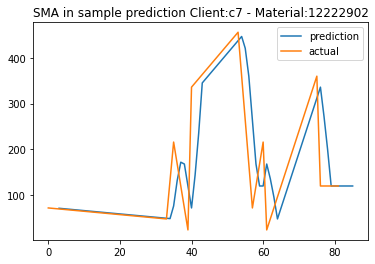

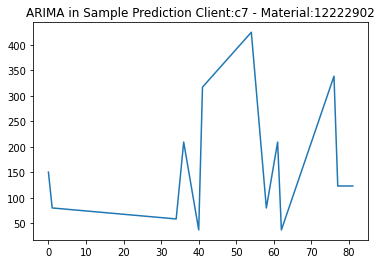

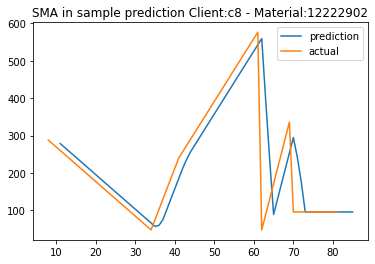

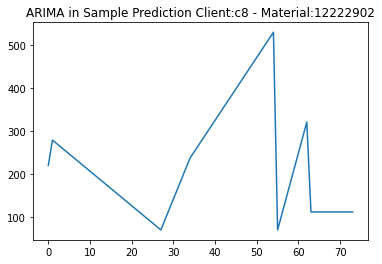

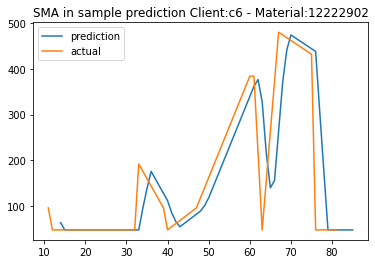

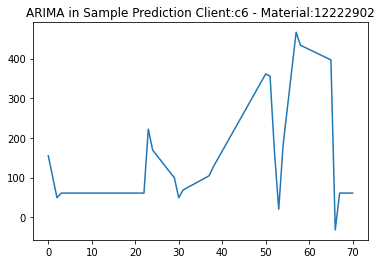

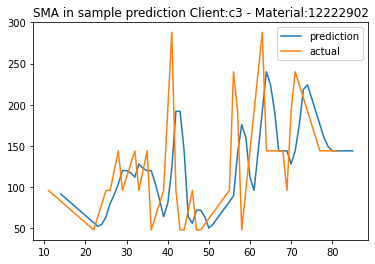

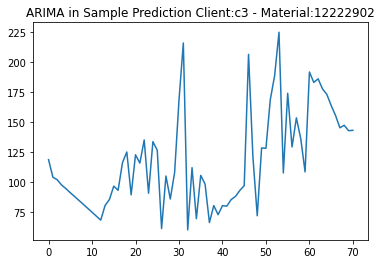

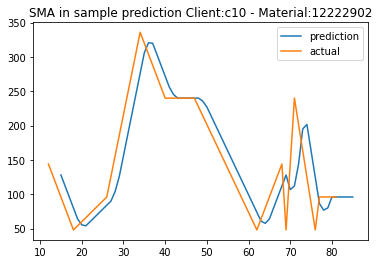

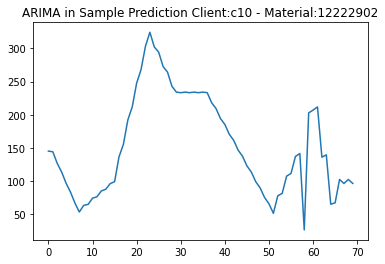

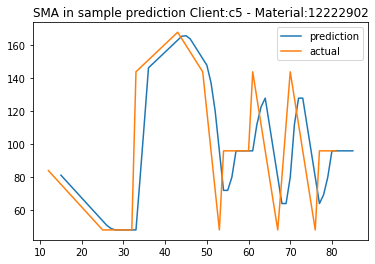

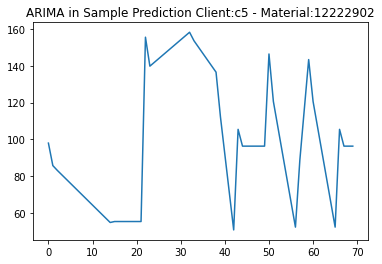

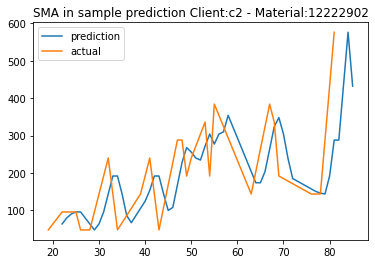

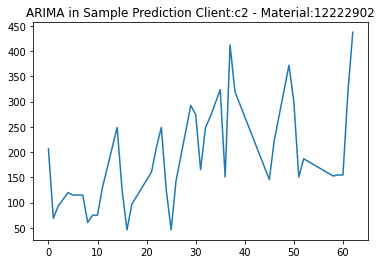

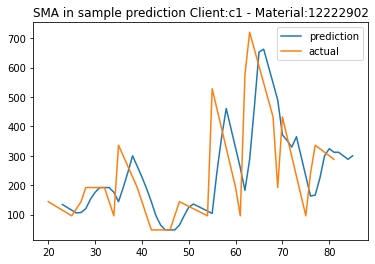

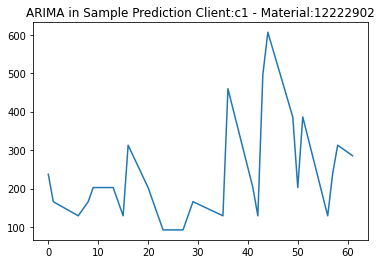

In [ ]:
prepare_output()

## References

[1]"The ARIMA Procedure", Dms.umontreal.ca, 2020. [Online]. Available: https://dms.umontreal.ca/~duchesne/chap7.pdf. [Accessed: 16- Jul- 2020]

[2]"Understanding ARIMA (Time Series Modeling)", Medium, 2020. [Online]. Available: https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8. [Accessed: 17- Jul- 2020]

---
---